# Corrected Label Prepare interpolated freeboard dataset for ANN, LSTM

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

## Setting ANN input data ===================================================

In [30]:
# Setting ANN input data ===================================================
import time
def make_input(data, fields, nearby, field = 'mean'):
    # Make input of ANN
    # data: input dataframe (2-m sampled ATL03 data with elev, stdev, total_ratio, pulse_count)
    # field: data field (list) ['elev', 'stdev', 'total_rati', ... ]
    # nearby: how many nearby pixels are used for ANN input? one pixel = 2m
    # (e.g. 5 nearby => consider +- 5 pixels from the center pixel => input: 10)
    
    start = time.time()
    first = True
    for i in range(nearby, len(data)-nearby-1):
        possible_point = True
        D = pd.DataFrame({'label': [data.label.iloc[i]]})
        for j in range(i-nearby, i+nearby+1):
            if data.x_atc.iloc[j] - data.x_atc.iloc[i] != (j-i)*2:
                # input data should be in 2 meter interval
                possible_point = False
            for field in fields:                
                fieldname = field + str(j-i)
                D[fieldname] = data[field].iloc[j]
        if possible_point:
            if first:
                dF = D
                first = False
            else:
                dF = dF.append(D)
        if i % 2000 == 0:
            end = time.time()
            print("now working on ... {0} / {1} ({2} %, {3} sec)"
                  .format(i, len(data), round(i/len(data)*100, 2), int(end-start)))
    dF = dF.reset_index(drop=True)
    return dF

In [3]:
# Setting ANN input data ===================================================
import time
def make_input_with_track(data, fields, nearby, field = 'mean'):
    # Make input of ANN
    # data: input dataframe (2-m sampled ATL03 data with elev, stdev, total_ratio, pulse_count)
    # field: data field (list) ['elev', 'stdev', 'total_rati', ... ]
    # nearby: how many nearby pixels are used for ANN input? one pixel = 2m
    # (e.g. 5 nearby => consider +- 5 pixels from the center pixel => input: 10)
    
    start = time.time()
    first = True
    for i in range(nearby, len(data)-nearby-1):
        possible_point = True
        D = pd.DataFrame({'label': [data.label.iloc[i]]})
        D['track'] = [data['track'].iloc[i]]
        for j in range(i-nearby, i+nearby+1):
            if data.x_atc.iloc[j] - data.x_atc.iloc[i] != (j-i)*2:
                # input data should be in 2 meter interval
                possible_point = False
            for field in fields:                
                fieldname = field + str(j-i)
                D[fieldname] = data[field].iloc[j]
        if possible_point:
            if first:
                dF = D
                first = False
            else:
                dF = dF.append(D)
        if i % 5000 == 0:
            end = time.time()
            print("now working on ... {0} / {1} ({2} %, {3} sec)"
                  .format(i, len(data), round(i/len(data)*100, 2), int(end-start)))
    dF = dF.reset_index(drop=True)
    return dF

## Prepare new parameter added shifted_labeled_10m_5km_corrected_new_sea_surface dataset for  LSTM

In [5]:
###### 10m 5km ########
import glob, os
import time
dir_path = "ATL03_labeled_data/cor_labeled_by_is2trackline_10m/relative_height_interpolated_h_diff/"
dest_path = "ATL03_labeled_data/cor_labeled_LSTM/"
filelist = sorted(glob.glob(dir_path + "ATL03_" + "*_labeled_10m_done_rel_height_interpolated_h_diff.csv"))


for file in filelist:
    print(file)
    start = time.time()
    labeled_data = pd.read_csv(file)#, index_col=0)   
    #display(labeled_data)
    
    shp1 = labeled_data[labeled_data[['x_atc','label']].duplicated()].shape
    shp2 = labeled_data[labeled_data[['x_atc']].duplicated()].shape
    
    if(shp1 != shp2):
        print(shp1)
        print(shp2)
    
    #duplicated = labeled_data[labeled_data[['x_atc', 'label']].duplicated(keep=False)]
    dup_removed = labeled_data.drop_duplicates(subset=['x_atc','label'])
    #dup_removed = labeled_data.drop_duplicates(subset=['x_atc'])
    
    print(dup_removed.shape)
    
    shp1 = dup_removed[dup_removed[['x_atc','label']].duplicated()].shape
    shp2 = dup_removed[dup_removed[['x_atc']].duplicated()].shape
    
    if(shp1 != shp2):
        print(shp1)
        print(shp2)
    
    display(dup_removed)
    print("done")
    #break
    #dup_removed.to_csv(file.replace(dir_path, dest_path).replace(".csv", "_dr.csv"))

    break
    
    # Make dataset for ANN -------------------------------------
    dataset = make_input(dup_removed, ['h_cor_mean', 'h_diff', 'rel_height_min_elev', 'height_sd', 'pcnth_mean', 'pcnt_mean',  'bcnt_mean', 'brate_mean'], 2)  
    print("Dataset is ready!")
    dataset.to_csv(file.replace(dir_path, dest_path).replace("_labeled_10m_done_rel_height_interpolated_h_diff.csv", "_ann_new_param.csv"))
    
    del labeled_data, dup_removed, dataset
    #break
    end = time.time() - start
    print("Time per file is ",end)
    print("------------ File done ------------")
print("------------ Finish ------------")    
print("filelists ",len(filelist))

ATL03_labeled_data/cor_labeled_by_is2trackline_10m/relative_height_interpolated_h_diff/ATL03_20191104195311_05940510_T02CNA_gt1r_labeled_10m_done_rel_height_interpolated_h_diff.csv
(11439, 49)


,Unnamed: 0,Ori_Id,year,month,day,hour,minute,second,lat,lon,...,pix_x,pix_y,label,rel_sea_surf_min_elev,rel_sea_surf_avg_elev,rel_sea_surf_min_dist,rel_height_min_elev,rel_height_avg_elev,rel_height_min_dist_elev,h_diff
0,0,156246,2019,11,4,20,0,16,-75.686401,-170.867823,...,6870,11829,0,0.086317,0.309755,0.086317,0.295591,0.072152,0.295591,0.025448
1,1,156247,2019,11,4,20,0,16,-75.686420,-170.867836,...,6870,11828,0,0.086317,0.309755,0.086317,0.306343,0.082904,0.306343,0.005974
2,2,156248,2019,11,4,20,0,16,-75.686438,-170.867848,...,6870,11828,0,0.086317,0.309755,0.086317,0.265272,0.041833,0.265272,0.002445
3,3,156249,2019,11,4,20,0,16,-75.686451,-170.867856,...,6870,11828,0,0.086317,0.309755,0.086317,0.269483,0.046044,0.269483,-0.009686
4,4,156250,2019,11,4,20,0,16,-75.686470,-170.867868,...,6870,11828,0,0.086317,0.309755,0.086317,0.239664,0.016225,0.239664,-0.017654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11434,11434,167882,2019,11,4,20,0,19,-75.892486,-170.999644,...,7578,9647,0,0.086141,0.214229,0.086141,0.544563,0.416475,0.544563,0.042118
11435,11435,167883,2019,11,4,20,0,19,-75.892505,-170.999656,...,7578,9647,0,0.086141,0.214229,0.086141,0.577942,0.449854,0.577942,0.007362
11436,11436,167884,2019,11,4,20,0,19,-75.892523,-170.999668,...,7578,9647,0,0.086141,0.214229,0.086141,0.509740,0.381652,0.509740,-0.002277
11437,11437,167885,2019,11,4,20,0,19,-75.892542,-170.999680,...,7578,9647,0,0.086141,0.214229,0.086141,0.532064,0.403976,0.532064,-0.003410


done
now working on ... 2000 / 11439 (17.48 %, 17 sec)
now working on ... 4000 / 11439 (34.97 %, 34 sec)
now working on ... 6000 / 11439 (52.45 %, 50 sec)
now working on ... 8000 / 11439 (69.94 %, 66 sec)
now working on ... 10000 / 11439 (87.42 %, 83 sec)
Dataset is ready!
Time per file is  96.16151309013367
------------ File done ------------
ATL03_labeled_data/cor_labeled_by_is2trackline_10m/relative_height_interpolated_h_diff/ATL03_20191104195311_05940510_T02CNA_gt2r_labeled_10m_done_rel_height_interpolated_h_diff.csv
(698, 49)


,Unnamed: 0,Ori_Id,year,month,day,hour,minute,second,lat,lon,...,pix_x,pix_y,label,rel_sea_surf_min_elev,rel_sea_surf_avg_elev,rel_sea_surf_min_dist,rel_height_min_elev,rel_height_avg_elev,rel_height_min_dist_elev,h_diff
0,0,171152,2019,11,4,20,0,16,-75.686538,-170.991671,...,7203,11880,0,NaN,NaN,NaN,NaN,NaN,NaN,0.002182
1,1,171153,2019,11,4,20,0,16,-75.686557,-170.991683,...,7203,11880,0,NaN,NaN,NaN,NaN,NaN,NaN,0.017456
2,2,171154,2019,11,4,20,0,16,-75.686569,-170.991691,...,7203,11880,0,NaN,NaN,NaN,NaN,NaN,NaN,-0.038818
3,3,171155,2019,11,4,20,0,16,-75.686588,-170.991703,...,7203,11880,0,NaN,NaN,NaN,NaN,NaN,NaN,-0.017403
4,4,171156,2019,11,4,20,0,16,-75.686607,-170.991715,...,7203,11879,0,NaN,NaN,NaN,NaN,NaN,NaN,-0.012680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
693,693,171845,2019,11,4,20,0,16,-75.698790,-170.999675,...,7245,11750,0,NaN,NaN,NaN,NaN,NaN,NaN,-0.002983
694,694,171846,2019,11,4,20,0,16,-75.698809,-170.999687,...,7245,11750,0,NaN,NaN,NaN,NaN,NaN,NaN,0.000046
695,695,171847,2019,11,4,20,0,16,-75.698821,-170.999695,...,7245,11750,0,NaN,NaN,NaN,NaN,NaN,NaN,-0.013039
696,696,171848,2019,11,4,20,0,16,-75.698840,-170.999707,...,7245,11750,0,NaN,NaN,NaN,NaN,NaN,NaN,-0.007290


done
Dataset is ready!
Time per file is  5.923595905303955
------------ File done ------------
ATL03_labeled_data/cor_labeled_by_is2trackline_10m/relative_height_interpolated_h_diff/ATL03_20191104195311_05940510_T02CNB_gt1r_labeled_10m_done_rel_height_interpolated_h_diff.csv
(46738, 49)


,Unnamed: 0,Ori_Id,year,month,day,hour,minute,second,lat,lon,...,pix_x,pix_y,label,rel_sea_surf_min_elev,rel_sea_surf_avg_elev,rel_sea_surf_min_dist,rel_height_min_elev,rel_height_avg_elev,rel_height_min_dist_elev,h_diff
0,0,109802,2019,11,4,20,0,2,-74.827347,-170.351997,...,9354,12143,2,0.033269,0.372500,0.178617,0.327001,-0.012230,0.181652,-0.020248
1,1,109803,2019,11,4,20,0,2,-74.827366,-170.352008,...,9354,12143,2,0.033269,0.372515,0.178617,0.338449,-0.000797,0.193101,-0.008980
2,2,109804,2019,11,4,20,0,2,-74.827397,-170.352027,...,9354,12143,2,0.033269,0.372515,0.178617,0.334117,-0.005128,0.188769,0.000000
3,3,109805,2019,11,4,20,0,2,-74.827403,-170.352030,...,9354,12143,2,0.033269,0.372515,0.178617,0.280663,-0.058583,0.135315,0.002434
4,4,109806,2019,11,4,20,0,2,-74.827422,-170.352041,...,9354,12143,2,0.033269,0.372515,0.178617,0.303093,-0.036153,0.157745,-0.012291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46733,46733,160991,2019,11,4,20,0,17,-75.770478,-170.922009,...,12614,2161,0,0.086317,0.313940,0.155867,0.261465,0.033842,0.191914,-0.012413
46734,46734,160992,2019,11,4,20,0,17,-75.770497,-170.922021,...,12614,2161,0,0.086317,0.313940,0.155867,0.234780,0.007157,0.165230,0.012253
46735,46735,160993,2019,11,4,20,0,17,-75.770515,-170.922033,...,12614,2161,0,0.086317,0.313940,0.155867,0.284301,0.056678,0.214751,-0.014629
46736,46736,160994,2019,11,4,20,0,17,-75.770534,-170.922045,...,12614,2160,0,0.086317,0.313940,0.155867,0.266451,0.038828,0.196900,-0.025028


done
now working on ... 2000 / 46738 (4.28 %, 15 sec)
now working on ... 4000 / 46738 (8.56 %, 32 sec)
now working on ... 6000 / 46738 (12.84 %, 48 sec)
now working on ... 8000 / 46738 (17.12 %, 64 sec)
now working on ... 10000 / 46738 (21.4 %, 81 sec)
now working on ... 12000 / 46738 (25.68 %, 98 sec)
now working on ... 14000 / 46738 (29.95 %, 115 sec)
now working on ... 16000 / 46738 (34.23 %, 132 sec)
now working on ... 18000 / 46738 (38.51 %, 150 sec)
now working on ... 20000 / 46738 (42.79 %, 167 sec)
now working on ... 22000 / 46738 (47.07 %, 186 sec)
now working on ... 24000 / 46738 (51.35 %, 205 sec)
now working on ... 26000 / 46738 (55.63 %, 224 sec)
now working on ... 28000 / 46738 (59.91 %, 244 sec)
now working on ... 30000 / 46738 (64.19 %, 264 sec)
now working on ... 32000 / 46738 (68.47 %, 285 sec)
now working on ... 34000 / 46738 (72.75 %, 305 sec)
now working on ... 36000 / 46738 (77.03 %, 327 sec)
now working on ... 38000 / 46738 (81.3 %, 348 sec)
now working on ... 40

,Unnamed: 0,Ori_Id,year,month,day,hour,minute,second,lat,lon,...,pix_x,pix_y,label,rel_sea_surf_min_elev,rel_sea_surf_avg_elev,rel_sea_surf_min_dist,rel_height_min_elev,rel_height_avg_elev,rel_height_min_dist_elev,h_diff
0,0,125224,2019,11,4,20,0,2,-74.789350,-170.446743,...,9554,12602,0,0.108794,0.140518,0.172241,0.505232,0.473508,0.441785,-0.006088
1,1,125225,2019,11,4,20,0,2,-74.789369,-170.446754,...,9554,12602,0,0.108794,0.140518,0.172241,0.470450,0.438727,0.407003,-0.024788
2,2,125226,2019,11,4,20,0,2,-74.789387,-170.446765,...,9554,12601,0,0.108794,0.140518,0.172241,0.512556,0.480833,0.449109,-0.077721
3,3,125227,2019,11,4,20,0,2,-74.789400,-170.446773,...,9554,12601,0,0.108794,0.140518,0.172241,0.541458,0.509734,0.478011,-0.045898
4,4,125228,2019,11,4,20,0,2,-74.789419,-170.446784,...,9554,12601,0,0.108794,0.140518,0.172241,0.528244,0.496520,0.464797,-0.041260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44865,44865,171845,2019,11,4,20,0,16,-75.698790,-170.999675,...,12698,2972,0,0.129652,0.238609,0.193020,0.404534,0.295577,0.341166,-0.002983
44866,44866,171846,2019,11,4,20,0,16,-75.698809,-170.999687,...,12698,2972,0,0.129652,0.238609,0.193020,0.470482,0.361525,0.407115,0.000046
44867,44867,171847,2019,11,4,20,0,16,-75.698821,-170.999695,...,12698,2972,0,0.129652,0.238609,0.193020,0.439988,0.331031,0.376620,-0.013039
44868,44868,171848,2019,11,4,20,0,16,-75.698840,-170.999707,...,12698,2972,0,0.129652,0.238609,0.193020,0.472623,0.363666,0.409255,-0.007290


done
now working on ... 2000 / 44870 (4.46 %, 16 sec)
now working on ... 4000 / 44870 (8.91 %, 32 sec)
now working on ... 6000 / 44870 (13.37 %, 48 sec)
now working on ... 8000 / 44870 (17.83 %, 64 sec)
now working on ... 10000 / 44870 (22.29 %, 80 sec)
now working on ... 12000 / 44870 (26.74 %, 97 sec)
now working on ... 14000 / 44870 (31.2 %, 113 sec)
now working on ... 16000 / 44870 (35.66 %, 131 sec)
now working on ... 18000 / 44870 (40.12 %, 148 sec)
now working on ... 20000 / 44870 (44.57 %, 166 sec)
now working on ... 22000 / 44870 (49.03 %, 185 sec)
now working on ... 24000 / 44870 (53.49 %, 204 sec)
now working on ... 26000 / 44870 (57.95 %, 224 sec)
now working on ... 28000 / 44870 (62.4 %, 244 sec)
now working on ... 30000 / 44870 (66.86 %, 264 sec)
now working on ... 32000 / 44870 (71.32 %, 284 sec)
now working on ... 34000 / 44870 (75.77 %, 305 sec)
now working on ... 36000 / 44870 (80.23 %, 327 sec)
now working on ... 38000 / 44870 (84.69 %, 348 sec)
now working on ... 40

,Unnamed: 0,Ori_Id,year,month,day,hour,minute,second,lat,lon,...,pix_x,pix_y,label,rel_sea_surf_min_elev,rel_sea_surf_avg_elev,rel_sea_surf_min_dist,rel_height_min_elev,rel_height_avg_elev,rel_height_min_dist_elev,h_diff
0,0,69057,2019,11,4,19,59,47,-73.894892,-169.846103,...,8050,12308,0,0.340913,0.405129,0.354868,0.500207,0.435991,0.486252,0.017502
1,1,69058,2019,11,4,19,59,47,-73.894911,-169.846113,...,8050,12308,0,0.340913,0.405129,0.354868,0.465494,0.401278,0.451539,0.044289
2,2,69059,2019,11,4,19,59,47,-73.894936,-169.846126,...,8050,12308,0,0.340913,0.405129,0.354868,0.550214,0.485998,0.536259,-0.060127
3,3,69060,2019,11,4,19,59,47,-73.894948,-169.846132,...,8050,12308,0,0.340913,0.405129,0.354868,0.471623,0.407407,0.457668,-0.050583
4,4,69061,2019,11,4,19,59,47,-73.894961,-169.846138,...,8050,12308,0,0.340913,0.405129,0.354868,0.443032,0.378816,0.429077,-0.062569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39035,39035,111581,2019,11,4,20,0,3,-74.872872,-170.377745,...,11458,1954,0,0.239007,0.419860,0.324905,0.586945,0.406093,0.501048,0.000000
39036,39036,111582,2019,11,4,20,0,3,-74.872884,-170.377752,...,11458,1954,0,0.239007,0.419860,0.324905,0.530625,0.349773,0.444728,0.036205
39037,39037,111583,2019,11,4,20,0,3,-74.872897,-170.377759,...,11458,1954,0,0.239007,0.419860,0.324905,0.644410,0.463558,0.558513,-0.010487
39038,39038,111584,2019,11,4,20,0,3,-74.872909,-170.377766,...,11458,1954,0,0.239007,0.419860,0.324905,0.586323,0.405471,0.500426,0.004547


done
now working on ... 2000 / 39040 (5.12 %, 16 sec)
now working on ... 4000 / 39040 (10.25 %, 32 sec)
now working on ... 6000 / 39040 (15.37 %, 48 sec)
now working on ... 8000 / 39040 (20.49 %, 65 sec)
now working on ... 10000 / 39040 (25.61 %, 82 sec)
now working on ... 12000 / 39040 (30.74 %, 99 sec)
now working on ... 14000 / 39040 (35.86 %, 115 sec)
now working on ... 16000 / 39040 (40.98 %, 133 sec)
now working on ... 18000 / 39040 (46.11 %, 151 sec)
now working on ... 20000 / 39040 (51.23 %, 170 sec)
now working on ... 22000 / 39040 (56.35 %, 188 sec)
now working on ... 24000 / 39040 (61.48 %, 208 sec)
now working on ... 26000 / 39040 (66.6 %, 227 sec)
now working on ... 28000 / 39040 (71.72 %, 247 sec)
now working on ... 30000 / 39040 (76.84 %, 268 sec)
now working on ... 32000 / 39040 (81.97 %, 289 sec)
now working on ... 34000 / 39040 (87.09 %, 314 sec)
now working on ... 36000 / 39040 (92.21 %, 335 sec)
now working on ... 38000 / 39040 (97.34 %, 356 sec)
Dataset is ready!
T

,Unnamed: 0,Ori_Id,year,month,day,hour,minute,second,lat,lon,...,pix_x,pix_y,label,rel_sea_surf_min_elev,rel_sea_surf_avg_elev,rel_sea_surf_min_dist,rel_height_min_elev,rel_height_avg_elev,rel_height_min_dist_elev,h_diff
0,0,83016,2019,11,4,19,59,47,-73.901593,-169.959490,...,8405,12296,0,0.116004,0.380480,0.240533,0.591086,0.326610,0.466557,0.008125
1,1,83017,2019,11,4,19,59,47,-73.901617,-169.959503,...,8405,12296,0,0.116004,0.380480,0.240533,0.638357,0.373881,0.513829,0.018753
2,2,83018,2019,11,4,19,59,47,-73.901624,-169.959506,...,8405,12296,0,0.116004,0.380480,0.240533,0.793565,0.529089,0.669037,0.021805
3,3,83019,2019,11,4,19,59,47,-73.901642,-169.959516,...,8405,12296,0,0.116004,0.380480,0.240533,0.826576,0.562100,0.702047,0.000000
4,4,83020,2019,11,4,19,59,47,-73.901661,-169.959526,...,8405,12296,0,0.116004,0.380480,0.240533,0.718176,0.453700,0.593648,0.046906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42149,42149,127443,2019,11,4,20,0,3,-74.873411,-170.495062,...,11792,2005,0,0.191444,0.295437,0.242757,0.497973,0.393980,0.446659,0.012901
42150,42150,127444,2019,11,4,20,0,3,-74.873430,-170.495072,...,11792,2004,0,0.191444,0.295437,0.242757,0.463612,0.359619,0.412299,-0.001694
42151,42151,127445,2019,11,4,20,0,3,-74.873443,-170.495080,...,11792,2004,0,0.191444,0.295437,0.242757,0.637809,0.533816,0.586496,0.088432
42152,42152,127446,2019,11,4,20,0,3,-74.873461,-170.495091,...,11792,2004,0,0.191444,0.295437,0.242757,0.552961,0.448969,0.501648,0.019032


done
now working on ... 2000 / 42154 (4.74 %, 16 sec)
now working on ... 4000 / 42154 (9.49 %, 32 sec)
now working on ... 6000 / 42154 (14.23 %, 49 sec)
now working on ... 8000 / 42154 (18.98 %, 65 sec)
now working on ... 10000 / 42154 (23.72 %, 82 sec)
now working on ... 12000 / 42154 (28.47 %, 98 sec)
now working on ... 14000 / 42154 (33.21 %, 116 sec)
now working on ... 16000 / 42154 (37.96 %, 133 sec)
now working on ... 18000 / 42154 (42.7 %, 151 sec)
now working on ... 20000 / 42154 (47.45 %, 169 sec)
now working on ... 22000 / 42154 (52.19 %, 187 sec)
now working on ... 24000 / 42154 (56.93 %, 207 sec)
now working on ... 26000 / 42154 (61.68 %, 226 sec)
now working on ... 28000 / 42154 (66.42 %, 247 sec)
now working on ... 30000 / 42154 (71.17 %, 267 sec)
now working on ... 32000 / 42154 (75.91 %, 288 sec)
now working on ... 34000 / 42154 (80.66 %, 309 sec)
now working on ... 36000 / 42154 (85.4 %, 330 sec)
now working on ... 38000 / 42154 (90.15 %, 351 sec)
now working on ... 40

,Unnamed: 0,Ori_Id,year,month,day,hour,minute,second,lat,lon,...,pix_x,pix_y,label,rel_sea_surf_min_elev,rel_sea_surf_avg_elev,rel_sea_surf_min_dist,rel_height_min_elev,rel_height_avg_elev,rel_height_min_dist_elev,h_diff
0,0,32261,2019,11,26,18,26,58,-74.365365,-162.565989,...,5296,6955,0,0.349940,0.497036,0.397294,1.008034,0.860938,0.960681,0.030464
1,1,32262,2019,11,26,18,26,58,-74.365377,-162.565996,...,5296,6955,0,0.349940,0.497036,0.397294,0.980903,0.833807,0.933550,0.026947
2,2,32263,2019,11,26,18,26,58,-74.365396,-162.566006,...,5296,6954,0,0.349940,0.497036,0.397294,1.010222,0.863126,0.962869,0.010887
3,3,32264,2019,11,26,18,26,58,-74.365415,-162.566017,...,5296,6954,0,0.349940,0.497036,0.397294,1.054251,0.907155,1.006898,0.014725
4,4,32265,2019,11,26,18,26,58,-74.365433,-162.566027,...,5296,6954,0,0.349940,0.497036,0.397294,1.099371,0.952275,1.052018,0.018593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25088,25088,58462,2019,11,26,18,27,6,-74.860061,-162.841794,...,7688,1988,0,0.277566,0.562096,0.371476,1.780548,1.496018,1.686637,0.000000
25089,25089,58463,2019,11,26,18,27,6,-74.860073,-162.841801,...,7688,1988,0,0.277566,0.562096,0.371476,1.850618,1.566088,1.756707,0.000000
25090,25090,58464,2019,11,26,18,27,6,-74.860092,-162.841812,...,7688,1988,0,0.277566,0.562096,0.371476,1.826577,1.542048,1.732667,0.025009
25091,25091,58465,2019,11,26,18,27,6,-74.860110,-162.841822,...,7688,1988,0,0.277566,0.562096,0.371476,1.848529,1.563999,1.754618,-0.006313


done
now working on ... 2000 / 25093 (7.97 %, 16 sec)
now working on ... 4000 / 25093 (15.94 %, 32 sec)
now working on ... 6000 / 25093 (23.91 %, 49 sec)
now working on ... 8000 / 25093 (31.88 %, 65 sec)
now working on ... 10000 / 25093 (39.85 %, 82 sec)
now working on ... 12000 / 25093 (47.82 %, 99 sec)
now working on ... 14000 / 25093 (55.79 %, 116 sec)
now working on ... 16000 / 25093 (63.76 %, 132 sec)
now working on ... 18000 / 25093 (71.73 %, 150 sec)
now working on ... 20000 / 25093 (79.7 %, 168 sec)
now working on ... 22000 / 25093 (87.67 %, 188 sec)
now working on ... 24000 / 25093 (95.64 %, 206 sec)
Dataset is ready!
Time per file is  218.2448935508728
------------ File done ------------
ATL03_labeled_data/cor_labeled_by_is2trackline_10m/relative_height_interpolated_h_diff/ATL03_20191126182014_09290510_T03CWT_gt2r_labeled_10m_done_rel_height_interpolated_h_diff.csv
(20911, 49)


,Unnamed: 0,Ori_Id,year,month,day,hour,minute,second,lat,lon,...,pix_x,pix_y,label,rel_sea_surf_min_elev,rel_sea_surf_avg_elev,rel_sea_surf_min_dist,rel_height_min_elev,rel_height_avg_elev,rel_height_min_dist_elev,h_diff
0,0,25002,2019,11,26,18,26,59,-74.408964,-162.703288,...,5828,6618,0,0.273016,0.483751,0.273016,0.307085,0.096350,0.307085,-0.060791
1,1,25003,2019,11,26,18,26,59,-74.408982,-162.703298,...,5829,6617,0,0.153125,0.507888,0.273016,0.466232,0.111469,0.346342,0.020546
2,2,25004,2019,11,26,18,26,59,-74.408995,-162.703304,...,5829,6617,0,0.153125,0.507888,0.273016,0.425606,0.070843,0.305715,0.004135
3,3,25005,2019,11,26,18,26,59,-74.409014,-162.703314,...,5829,6617,0,0.153125,0.507888,0.273016,0.410185,0.055422,0.290294,-0.027657
4,4,25006,2019,11,26,18,26,59,-74.409032,-162.703324,...,5829,6617,0,0.153125,0.507888,0.273016,0.371664,0.016901,0.251773,-0.052750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20906,20906,47438,2019,11,26,18,27,6,-74.864896,-162.961574,...,8033,2039,0,0.305320,0.532356,0.348519,1.446169,1.219133,1.402970,0.079643
20907,20907,47439,2019,11,26,18,27,6,-74.864908,-162.961582,...,8033,2039,0,0.305320,0.532356,0.348519,1.335490,1.108453,1.292291,0.017212
20908,20908,47440,2019,11,26,18,27,6,-74.864927,-162.961593,...,8033,2039,0,0.305320,0.532356,0.348519,1.355771,1.128735,1.312572,0.011383
20909,20909,47441,2019,11,26,18,27,6,-74.864946,-162.961603,...,8033,2038,0,0.305320,0.532356,0.348519,1.415785,1.188749,1.372586,-0.024185


done
now working on ... 2000 / 20911 (9.56 %, 16 sec)
now working on ... 4000 / 20911 (19.13 %, 32 sec)
now working on ... 6000 / 20911 (28.69 %, 49 sec)
now working on ... 8000 / 20911 (38.26 %, 66 sec)
now working on ... 10000 / 20911 (47.82 %, 83 sec)
now working on ... 12000 / 20911 (57.39 %, 99 sec)
now working on ... 14000 / 20911 (66.95 %, 116 sec)
now working on ... 16000 / 20911 (76.51 %, 133 sec)
now working on ... 18000 / 20911 (86.08 %, 150 sec)
now working on ... 20000 / 20911 (95.64 %, 167 sec)
Dataset is ready!
Time per file is  177.03066611289978
------------ File done ------------
------------ Finish ------------
filelists  8


## all ow processed data prep for inferencing

In [34]:
###### 10m 5km ########
import glob, os
import time
dir_path = "ATL03_labeled_data/ow_labeled_10m_5km_corrected_new_sea_surface/"
dest_path = "ATL03_labeled_data/ow_labeled_10m_5km_corrected_new_sea_surface_LSTM_new_param_2/"
filelist = sorted(glob.glob(dir_path + "ATL03_" + "*_new_sea_surf.csv"))


for file in filelist:
    print(file)
    start = time.time()
    labeled_data = pd.read_csv(file)#, index_col=0)   
    #display(labeled_data)
    
    shp1 = labeled_data[labeled_data[['x_atc','label']].duplicated()].shape
    shp2 = labeled_data[labeled_data[['x_atc']].duplicated()].shape
    
    if(shp1 != shp2):
        print(shp1)
        print(shp2)
    
    #duplicated = labeled_data[labeled_data[['x_atc', 'label']].duplicated(keep=False)]
    dup_removed = labeled_data.drop_duplicates(subset=['x_atc','label'])
    #dup_removed = labeled_data.drop_duplicates(subset=['x_atc'])
    
    print(dup_removed.shape)
    
    shp1 = dup_removed[dup_removed[['x_atc','label']].duplicated()].shape
    shp2 = dup_removed[dup_removed[['x_atc']].duplicated()].shape
    
    if(shp1 != shp2):
        print(shp1)
        print(shp2)
    
    display(dup_removed)
    print("done")
#     break
    #dup_removed.to_csv(file.replace(dir_path, dest_path).replace(".csv", "_dr.csv"))

    break
    ### h_diff calculation
    dup_removed['h_diff'] = dup_removed['h_cor_mean'] - dup_removed['h_cor_med']
    dup_removed = dup_removed.rename(columns={"freeboard_min_elev": "rel_height_min_elev"})

    # Make dataset for ANN -------------------------------------
    dataset = make_input(dup_removed, ['h_cor_mean', 'h_diff', 'rel_height_min_elev', 'height_sd', 'pcnth_mean', 'pcnt_mean',  'bcnt_mean', 'brate_mean'], 2)  
    print("Dataset is ready!")
    dataset.to_csv(file.replace(dir_path, dest_path).replace("_labeled_10m_z_score_5km_atl07_sea_surf_dr_new_sea_surf.csv", "_ann_new_param.csv"))
    
    del labeled_data, dup_removed, dataset
    #break
    end = time.time() - start
    print("Time per file is ",end)
    print("------------ File done ------------")
print("------------ Finish ------------")    
print("filelists ",len(filelist))

ATL03_labeled_data/ow_labeled_10m_5km_corrected_new_sea_surface/ATL03_20191103184432_05780510_gt1r_labeled_10m_z_score_5km_atl07_sea_surf_dr_new_sea_surf.csv
(1130, 56)
(1562, 56)
(149298, 56)
(0, 56)
(432, 56)


,Unnamed: 0,lon,h_ref,height,year,month,day,hour,minute,second,...,sea_surf_min_dist,freeboard_min_elev,freeboard_avg_elev,freeboard_min_dist_elev,height_diff_03_07,h_ref_freeboard_h_mean,h_ref_freeboard_h_med,new_h_ref,new_s_ref,freeboard_new_h_ref
0,0,-151.484900,0.447774,-0.054974,2019,11,3,18,50,54,...,0.545018,0.185182,0.036384,0.092031,0.692023,0.189275,0.205041,0.513545,0.002784,0.123504
1,1,-151.484912,0.447774,-0.048920,2019,11,3,18,50,54,...,0.545018,0.227590,0.078792,0.134439,0.728376,0.231682,0.240990,0.513545,0.002784,0.165911
2,2,-151.484921,0.447774,-0.048878,2019,11,3,18,50,54,...,0.545018,0.271946,0.123148,0.178795,0.772691,0.276039,0.276039,0.513545,0.002784,0.210268
3,3,-151.484924,0.447774,-0.048837,2019,11,3,18,50,54,...,0.545018,0.277363,0.128566,0.184212,0.778067,0.281456,0.281456,0.513545,0.002784,0.215685
4,4,-151.484936,0.447774,-0.048796,2019,11,3,18,50,54,...,0.545018,0.158453,0.009656,0.065302,0.659116,0.162546,0.155134,0.513545,0.002784,0.096775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150423,151435,-153.614143,0.291597,0.171146,2019,11,3,18,51,53,...,0.675802,0.056190,-0.315405,0.000000,0.504656,0.384205,0.402618,0.815499,0.001148,-0.139697
150424,151436,-153.614156,0.291598,0.171072,2019,11,3,18,51,53,...,0.726804,0.107193,-0.264403,0.000000,0.555732,0.435206,0.405871,0.815499,0.001148,-0.088695
150425,151437,-153.614170,0.291600,0.170998,2019,11,3,18,51,53,...,0.727063,0.107452,-0.264143,0.000000,0.556065,0.435464,0.400166,0.815499,0.001148,-0.088436
150426,151438,-153.614183,0.291601,0.170924,2019,11,3,18,51,53,...,0.720151,0.100540,-0.271056,0.000000,0.549227,0.428550,0.447608,0.815499,0.001148,-0.095348


done
now working on ... 2000 / 149298 (1.34 %, 16 sec)
now working on ... 4000 / 149298 (2.68 %, 33 sec)
now working on ... 6000 / 149298 (4.02 %, 49 sec)
now working on ... 8000 / 149298 (5.36 %, 66 sec)
now working on ... 10000 / 149298 (6.7 %, 82 sec)
now working on ... 12000 / 149298 (8.04 %, 99 sec)
now working on ... 14000 / 149298 (9.38 %, 116 sec)
now working on ... 16000 / 149298 (10.72 %, 133 sec)
now working on ... 18000 / 149298 (12.06 %, 150 sec)
now working on ... 20000 / 149298 (13.4 %, 166 sec)
now working on ... 22000 / 149298 (14.74 %, 184 sec)
now working on ... 24000 / 149298 (16.08 %, 202 sec)
now working on ... 26000 / 149298 (17.41 %, 220 sec)
now working on ... 28000 / 149298 (18.75 %, 238 sec)
now working on ... 30000 / 149298 (20.09 %, 257 sec)
now working on ... 32000 / 149298 (21.43 %, 277 sec)
now working on ... 34000 / 149298 (22.77 %, 296 sec)
now working on ... 36000 / 149298 (24.11 %, 316 sec)
now working on ... 38000 / 149298 (25.45 %, 336 sec)
now wor

,Unnamed: 0,lon,h_ref,height,year,month,day,hour,minute,second,...,sea_surf_min_dist,freeboard_min_elev,freeboard_avg_elev,freeboard_min_dist_elev,height_diff_03_07,h_ref_freeboard_h_mean,h_ref_freeboard_h_med,new_h_ref,new_s_ref,freeboard_new_h_ref
0,0,-151.589087,0.558960,0.165555,2019,11,3,18,50,54,...,0.778109,0.201368,-0.047044,0.000000,0.612554,0.219149,0.187983,0.638140,NaN,0.139969
1,1,-151.589099,0.558960,0.171446,2019,11,3,18,50,54,...,0.745344,0.168604,-0.081947,0.000000,0.573898,0.186385,0.183093,0.638140,NaN,0.107204
2,2,-151.589102,0.558960,0.177337,2019,11,3,18,50,54,...,0.745344,0.265675,0.015124,0.097071,0.665078,0.283456,0.315427,0.638140,NaN,0.204275
3,3,-151.589111,0.558960,0.183229,2019,11,3,18,50,54,...,0.745344,0.322189,0.071639,0.153586,0.715701,0.339970,0.384213,0.638140,NaN,0.260790
4,4,-151.589120,0.558960,0.189120,2019,11,3,18,50,54,...,0.745344,0.292336,0.041785,0.123732,0.679956,0.310117,0.452634,0.638140,NaN,0.230936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141738,148681,-153.746138,0.290805,0.047329,2019,11,3,18,51,53,...,0.687394,0.171043,-0.210314,0.079258,0.719323,0.475847,0.478319,0.737703,0.001696,0.028949
141739,148682,-153.746151,0.290804,0.047296,2019,11,3,18,51,53,...,0.687394,0.091785,-0.289572,0.000000,0.640099,0.396591,0.469555,0.737703,0.001696,-0.050309
141740,148683,-153.746165,0.290802,0.047263,2019,11,3,18,51,53,...,0.687394,0.183910,-0.197447,0.092125,0.732257,0.488717,0.501615,0.737703,0.001696,0.041816
141741,148684,-153.746178,0.290801,0.047229,2019,11,3,18,51,53,...,0.687394,0.213581,-0.167776,0.121796,0.761961,0.518389,0.552146,0.737703,0.001696,0.071487


done
now working on ... 2000 / 139710 (1.43 %, 15 sec)
now working on ... 4000 / 139710 (2.86 %, 32 sec)
now working on ... 6000 / 139710 (4.29 %, 49 sec)
now working on ... 8000 / 139710 (5.73 %, 66 sec)
now working on ... 10000 / 139710 (7.16 %, 82 sec)
now working on ... 12000 / 139710 (8.59 %, 98 sec)
now working on ... 14000 / 139710 (10.02 %, 114 sec)
now working on ... 16000 / 139710 (11.45 %, 130 sec)
now working on ... 18000 / 139710 (12.88 %, 147 sec)
now working on ... 20000 / 139710 (14.32 %, 165 sec)
now working on ... 22000 / 139710 (15.75 %, 182 sec)
now working on ... 24000 / 139710 (17.18 %, 200 sec)
now working on ... 26000 / 139710 (18.61 %, 218 sec)
now working on ... 28000 / 139710 (20.04 %, 237 sec)
now working on ... 30000 / 139710 (21.47 %, 256 sec)
now working on ... 32000 / 139710 (22.9 %, 275 sec)
now working on ... 34000 / 139710 (24.34 %, 294 sec)
now working on ... 36000 / 139710 (25.77 %, 314 sec)
now working on ... 38000 / 139710 (27.2 %, 333 sec)
now wo

,Unnamed: 0,lon,h_ref,height,year,month,day,hour,minute,second,...,sea_surf_min_dist,freeboard_min_elev,freeboard_avg_elev,freeboard_min_dist_elev,height_diff_03_07,h_ref_freeboard_h_mean,h_ref_freeboard_h_med,new_h_ref,new_s_ref,freeboard_new_h_ref
0,0,-151.694720,0.535449,0.062974,2019,11,3,18,50,54,...,0.661824,0.161885,0.022500,0.081227,0.680077,0.207602,0.207602,0.771237,NaN,-0.028186
1,1,-151.694723,0.535449,0.062986,2019,11,3,18,50,54,...,0.661824,0.080658,-0.058728,0.000000,0.598838,0.126374,0.125634,0.771237,NaN,-0.109414
2,2,-151.694735,0.535449,0.062997,2019,11,3,18,50,54,...,0.596020,0.014854,-0.124531,0.000000,0.533023,0.060571,0.060571,0.771237,NaN,-0.175217
3,3,-151.694740,0.535449,0.063009,2019,11,3,18,50,54,...,0.604060,0.022895,-0.116491,0.000000,0.541052,0.068611,0.045197,0.771237,NaN,-0.167177
4,4,-151.694746,0.535449,0.063020,2019,11,3,18,50,54,...,0.699096,0.117930,-0.021455,0.000000,0.636076,0.163646,0.109882,0.771237,NaN,-0.072141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137692,142712,-153.878604,0.470524,0.525650,2019,11,3,18,51,53,...,0.704328,0.499825,0.117760,0.384892,0.563569,0.618695,0.688584,0.655058,NaN,0.434162
137693,142713,-153.878613,0.470524,0.563714,2019,11,3,18,51,53,...,0.704328,0.605850,0.223786,0.490917,0.631531,0.724721,0.761209,0.655058,NaN,0.540187
137694,142714,-153.878627,0.470524,0.611248,2019,11,3,18,51,53,...,0.704328,0.596634,0.214570,0.481701,0.574780,0.715505,0.762033,0.655058,NaN,0.530971
137695,142715,-153.878641,0.470524,0.620719,2019,11,3,18,51,53,...,0.704328,0.604057,0.221993,0.489124,0.572733,0.722928,0.804631,0.655058,NaN,0.538394


done
now working on ... 2000 / 135612 (1.47 %, 15 sec)
now working on ... 4000 / 135612 (2.95 %, 32 sec)
now working on ... 6000 / 135612 (4.42 %, 49 sec)
now working on ... 8000 / 135612 (5.9 %, 66 sec)
now working on ... 10000 / 135612 (7.37 %, 83 sec)
now working on ... 12000 / 135612 (8.85 %, 99 sec)
now working on ... 14000 / 135612 (10.32 %, 116 sec)
now working on ... 16000 / 135612 (11.8 %, 133 sec)
now working on ... 18000 / 135612 (13.27 %, 150 sec)
now working on ... 20000 / 135612 (14.75 %, 168 sec)
now working on ... 22000 / 135612 (16.22 %, 186 sec)
now working on ... 24000 / 135612 (17.7 %, 204 sec)
now working on ... 26000 / 135612 (19.17 %, 223 sec)
now working on ... 28000 / 135612 (20.65 %, 242 sec)
now working on ... 30000 / 135612 (22.12 %, 261 sec)
now working on ... 32000 / 135612 (23.6 %, 280 sec)
now working on ... 34000 / 135612 (25.07 %, 299 sec)
now working on ... 36000 / 135612 (26.55 %, 319 sec)
now working on ... 38000 / 135612 (28.02 %, 338 sec)
now work

,Unnamed: 0,lon,h_ref,height,year,month,day,hour,minute,second,...,sea_surf_min_dist,freeboard_min_elev,freeboard_avg_elev,freeboard_min_dist_elev,height_diff_03_07,h_ref_freeboard_h_mean,h_ref_freeboard_h_med,new_h_ref,new_s_ref,freeboard_new_h_ref
0,0,-169.845205,0.412660,0.473313,2019,11,4,19,59,47,...,NaN,NaN,NaN,NaN,0.624937,0.685590,0.685590,0.404705,NaN,0.693545
1,1,-169.845211,0.412660,0.484726,2019,11,4,19,59,47,...,NaN,NaN,NaN,NaN,0.679942,0.752008,0.761354,0.404705,NaN,0.759963
2,2,-169.845223,0.412660,0.496139,2019,11,4,19,59,47,...,NaN,NaN,NaN,NaN,0.669435,0.752914,0.752914,0.404705,NaN,0.760868
3,3,-169.845229,0.412660,0.507551,2019,11,4,19,59,47,...,NaN,NaN,NaN,NaN,0.508088,0.602979,0.617948,0.404705,NaN,0.610933
4,4,-169.845238,0.412660,0.518964,2019,11,4,19,59,47,...,NaN,NaN,NaN,NaN,0.469938,0.576241,0.576241,0.404705,NaN,0.584196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93932,100939,-171.005771,0.227189,-0.091030,2019,11,4,20,0,19,...,0.001289,0.367144,0.037664,0.280736,0.373055,0.054836,0.049186,0.299882,0.000079,-0.017857
93933,100942,-171.005805,0.227189,-0.114716,2019,11,4,20,0,19,...,0.001289,0.316386,-0.013094,0.229978,0.345983,0.004078,0.025112,0.299882,0.000079,-0.068615
93934,100959,-171.006010,0.227189,-0.137225,2019,11,4,20,0,19,...,0.001289,0.320540,-0.008941,0.234132,0.372645,0.008231,0.015021,0.299882,0.000079,-0.064461
93935,100961,-171.006031,0.227189,-0.141420,2019,11,4,20,0,19,...,0.001289,0.344200,0.014719,0.257792,0.400501,0.031892,0.056401,0.299882,0.000079,-0.040801


done
now working on ... 2000 / 93316 (2.14 %, 16 sec)
now working on ... 4000 / 93316 (4.29 %, 33 sec)
now working on ... 6000 / 93316 (6.43 %, 50 sec)
now working on ... 8000 / 93316 (8.57 %, 67 sec)
now working on ... 10000 / 93316 (10.72 %, 84 sec)
now working on ... 12000 / 93316 (12.86 %, 101 sec)
now working on ... 14000 / 93316 (15.0 %, 118 sec)
now working on ... 16000 / 93316 (17.15 %, 135 sec)
now working on ... 18000 / 93316 (19.29 %, 153 sec)
now working on ... 20000 / 93316 (21.43 %, 171 sec)
now working on ... 22000 / 93316 (23.58 %, 188 sec)
now working on ... 24000 / 93316 (25.72 %, 207 sec)
now working on ... 26000 / 93316 (27.86 %, 226 sec)
now working on ... 28000 / 93316 (30.01 %, 245 sec)
now working on ... 30000 / 93316 (32.15 %, 264 sec)
now working on ... 32000 / 93316 (34.29 %, 284 sec)
now working on ... 34000 / 93316 (36.44 %, 305 sec)
now working on ... 36000 / 93316 (38.58 %, 325 sec)
now working on ... 38000 / 93316 (40.72 %, 345 sec)
now working on ... 40

,Unnamed: 0,lon,h_ref,height,year,month,day,hour,minute,second,...,sea_surf_min_dist,freeboard_min_elev,freeboard_avg_elev,freeboard_min_dist_elev,height_diff_03_07,h_ref_freeboard_h_mean,h_ref_freeboard_h_med,new_h_ref,new_s_ref,freeboard_new_h_ref
0,0,-169.951972,0.321875,0.014921,2019,11,4,19,59,47,...,0.380527,0.291928,-0.109523,0.000000,0.365607,0.058653,0.058653,0.353640,NaN,0.026888
1,1,-169.951979,0.321875,0.013502,2019,11,4,19,59,47,...,0.379749,0.460996,0.057885,0.169846,0.536093,0.227720,0.203245,0.353640,NaN,0.195955
2,2,-169.951992,0.321875,0.012083,2019,11,4,19,59,47,...,0.379749,0.483827,0.080716,0.192678,0.560344,0.250552,0.260828,0.353640,NaN,0.218787
3,3,-169.951995,0.321875,0.010664,2019,11,4,19,59,47,...,0.379749,0.353291,-0.049819,0.062142,0.431227,0.120016,0.120016,0.353640,NaN,0.088251
4,4,-169.952004,0.321875,0.009244,2019,11,4,19,59,47,...,0.379749,0.475336,0.072226,0.184187,0.554691,0.242061,0.250781,0.353640,NaN,0.210296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82652,90081,-171.010227,0.214838,0.188000,2019,11,4,20,0,16,...,0.193020,0.470095,0.136535,0.406728,0.411747,0.384909,0.410979,0.323761,NaN,0.275986
82653,90082,-171.010240,0.214838,0.206119,2019,11,4,20,0,16,...,0.193020,0.498836,0.165276,0.435469,0.422369,0.413650,0.442917,0.323761,NaN,0.304727
82654,90083,-171.010252,0.214838,0.221982,2019,11,4,20,0,16,...,0.193020,0.502738,0.169178,0.439371,0.410408,0.417552,0.438800,0.323761,NaN,0.308629
82655,90084,-171.010264,0.214838,0.219727,2019,11,4,20,0,16,...,0.193020,0.525612,0.192051,0.462244,0.435536,0.440425,0.483577,0.323761,NaN,0.331502


done
now working on ... 2000 / 82530 (2.42 %, 15 sec)
now working on ... 4000 / 82530 (4.85 %, 32 sec)
now working on ... 6000 / 82530 (7.27 %, 49 sec)
now working on ... 8000 / 82530 (9.69 %, 66 sec)
now working on ... 10000 / 82530 (12.12 %, 82 sec)
now working on ... 12000 / 82530 (14.54 %, 99 sec)
now working on ... 14000 / 82530 (16.96 %, 116 sec)
now working on ... 16000 / 82530 (19.39 %, 133 sec)
now working on ... 18000 / 82530 (21.81 %, 150 sec)
now working on ... 20000 / 82530 (24.23 %, 167 sec)
now working on ... 22000 / 82530 (26.66 %, 185 sec)
now working on ... 24000 / 82530 (29.08 %, 204 sec)
now working on ... 26000 / 82530 (31.5 %, 222 sec)
now working on ... 28000 / 82530 (33.93 %, 240 sec)
now working on ... 30000 / 82530 (36.35 %, 259 sec)
now working on ... 32000 / 82530 (38.77 %, 278 sec)
now working on ... 34000 / 82530 (41.2 %, 297 sec)
now working on ... 36000 / 82530 (43.62 %, 317 sec)
now working on ... 38000 / 82530 (46.04 %, 335 sec)
now working on ... 4000

,Unnamed: 0,lon,h_ref,height,year,month,day,hour,minute,second,...,sea_surf_min_dist,freeboard_min_elev,freeboard_avg_elev,freeboard_min_dist_elev,height_diff_03_07,h_ref_freeboard_h_mean,h_ref_freeboard_h_med,new_h_ref,new_s_ref,freeboard_new_h_ref
0,1,-167.078160,0.323701,-0.070433,2019,11,13,19,18,8,...,0.209502,0.125896,-0.479557,0.125896,0.405831,0.011697,0.021356,0.470961,0.000114,-0.135563
1,2,-167.078173,0.323701,-0.070911,2019,11,13,19,18,8,...,0.209502,0.197465,-0.407987,0.197465,0.477879,0.083267,0.096683,0.470961,0.000114,-0.063993
2,3,-167.078225,0.323701,-0.071903,2019,11,13,19,18,8,...,0.209502,0.236359,-0.369093,0.236359,0.517765,0.122160,0.128432,0.470961,0.000114,-0.025099
3,5,-167.078246,0.323701,-0.072930,2019,11,13,19,18,8,...,0.209502,0.136941,-0.468511,0.136941,0.419374,0.022743,0.034629,0.470961,0.000114,-0.124517
4,6,-167.078259,0.323701,-0.073444,2019,11,13,19,18,8,...,0.209502,0.145330,-0.460123,0.145330,0.428276,0.031131,0.032947,0.470961,0.000114,-0.116129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96866,101635,-168.427724,0.282988,-0.025373,2019,11,13,19,18,36,...,NaN,NaN,NaN,NaN,0.431306,0.122945,0.123612,0.388594,0.000032,0.017338
96867,101636,-168.427735,0.282988,-0.025720,2019,11,13,19,18,36,...,NaN,NaN,NaN,NaN,0.429611,0.120904,0.134355,0.388594,0.000032,0.015298
96868,101637,-168.427751,0.282988,-0.026066,2019,11,13,19,18,36,...,NaN,NaN,NaN,NaN,0.383880,0.074826,0.083814,0.388594,0.000032,-0.030780
96869,101638,-168.427768,0.282988,-0.025248,2019,11,13,19,18,36,...,NaN,NaN,NaN,NaN,0.420263,0.112027,0.141992,0.388594,0.000032,0.006421


done
now working on ... 2000 / 95500 (2.09 %, 16 sec)
now working on ... 4000 / 95500 (4.19 %, 32 sec)
now working on ... 6000 / 95500 (6.28 %, 48 sec)
now working on ... 8000 / 95500 (8.38 %, 65 sec)
now working on ... 10000 / 95500 (10.47 %, 81 sec)
now working on ... 12000 / 95500 (12.57 %, 97 sec)
now working on ... 14000 / 95500 (14.66 %, 114 sec)
now working on ... 16000 / 95500 (16.75 %, 131 sec)
now working on ... 18000 / 95500 (18.85 %, 147 sec)
now working on ... 20000 / 95500 (20.94 %, 165 sec)
now working on ... 22000 / 95500 (23.04 %, 182 sec)
now working on ... 24000 / 95500 (25.13 %, 199 sec)
now working on ... 26000 / 95500 (27.23 %, 217 sec)
now working on ... 28000 / 95500 (29.32 %, 235 sec)
now working on ... 30000 / 95500 (31.41 %, 254 sec)
now working on ... 32000 / 95500 (33.51 %, 273 sec)
now working on ... 34000 / 95500 (35.6 %, 292 sec)
now working on ... 36000 / 95500 (37.7 %, 312 sec)
now working on ... 38000 / 95500 (39.79 %, 332 sec)
now working on ... 4000

,Unnamed: 0,lon,h_ref,height,year,month,day,hour,minute,second,...,sea_surf_min_dist,freeboard_min_elev,freeboard_avg_elev,freeboard_min_dist_elev,height_diff_03_07,h_ref_freeboard_h_mean,h_ref_freeboard_h_med,new_h_ref,new_s_ref,freeboard_new_h_ref
0,0,-167.230861,0.270568,0.782411,2019,11,13,19,18,8,...,0.212340,0.973402,0.331849,0.973402,0.403331,0.915174,0.936738,0.467677,0.000325,0.718064
1,1,-167.230874,0.270568,0.887566,2019,11,13,19,18,8,...,0.023123,1.442957,0.788081,1.271242,0.406799,1.023798,1.015260,0.467677,0.000325,0.826688
2,2,-167.230887,0.270568,0.901725,2019,11,13,19,18,8,...,0.023123,1.336494,0.681618,1.164779,0.286177,0.917335,0.899531,0.467677,0.000325,0.720225
3,3,-167.230900,0.270568,0.915885,2019,11,13,19,18,8,...,0.023123,1.325628,0.670752,1.153913,0.261151,0.906468,0.969178,0.467677,0.000325,0.709359
4,4,-167.230913,0.270568,0.912475,2019,11,13,19,18,8,...,0.023123,1.496734,0.841859,1.325020,0.435668,1.077575,1.065551,0.467677,0.000325,0.880466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95365,99052,-168.575521,0.239825,-0.057495,2019,11,13,19,18,36,...,NaN,NaN,NaN,NaN,0.412836,0.115517,0.132461,0.389987,NaN,-0.034646
95366,99053,-168.575537,0.239825,-0.058769,2019,11,13,19,18,36,...,NaN,NaN,NaN,NaN,0.389345,0.090752,0.151108,0.389987,NaN,-0.059411
95367,99054,-168.575553,0.239825,-0.060043,2019,11,13,19,18,36,...,NaN,NaN,NaN,NaN,0.433104,0.133236,0.146168,0.389987,NaN,-0.016927
95368,99055,-168.575569,0.239825,-0.059316,2019,11,13,19,18,36,...,NaN,NaN,NaN,NaN,0.472420,0.173279,0.200180,0.389987,NaN,0.023116


done
now working on ... 2000 / 94259 (2.12 %, 15 sec)
now working on ... 4000 / 94259 (4.24 %, 32 sec)
now working on ... 6000 / 94259 (6.37 %, 47 sec)
now working on ... 8000 / 94259 (8.49 %, 64 sec)
now working on ... 10000 / 94259 (10.61 %, 81 sec)
now working on ... 12000 / 94259 (12.73 %, 98 sec)
now working on ... 14000 / 94259 (14.85 %, 114 sec)
now working on ... 16000 / 94259 (16.97 %, 131 sec)
now working on ... 18000 / 94259 (19.1 %, 148 sec)
now working on ... 20000 / 94259 (21.22 %, 164 sec)
now working on ... 22000 / 94259 (23.34 %, 182 sec)
now working on ... 24000 / 94259 (25.46 %, 199 sec)
now working on ... 26000 / 94259 (27.58 %, 217 sec)
now working on ... 28000 / 94259 (29.71 %, 236 sec)
now working on ... 30000 / 94259 (31.83 %, 255 sec)
now working on ... 32000 / 94259 (33.95 %, 275 sec)
now working on ... 34000 / 94259 (36.07 %, 295 sec)
now working on ... 36000 / 94259 (38.19 %, 316 sec)
now working on ... 38000 / 94259 (40.31 %, 337 sec)
now working on ... 400

,Unnamed: 0,lon,h_ref,height,year,month,day,hour,minute,second,...,sea_surf_min_dist,freeboard_min_elev,freeboard_avg_elev,freeboard_min_dist_elev,height_diff_03_07,h_ref_freeboard_h_mean,h_ref_freeboard_h_med,new_h_ref,new_s_ref,freeboard_new_h_ref
0,0,-167.384138,0.310757,0.498127,2019,11,13,19,18,9,...,0.453263,0.462441,-0.133589,0.426735,0.381871,0.569241,0.480927,0.760741,0.001296,0.119257
1,1,-167.384216,0.310757,0.278708,2019,11,13,19,18,9,...,0.453263,0.128831,-0.468040,0.093124,0.267679,0.235630,0.264458,0.760741,0.001296,-0.214354
2,2,-167.384230,0.310757,0.274141,2019,11,13,19,18,9,...,0.453263,0.149892,-0.446979,0.114185,0.293307,0.256691,0.290051,0.760741,0.001296,-0.193293
3,3,-167.384243,0.310757,0.269575,2019,11,13,19,18,9,...,0.453263,0.187116,-0.409754,0.151409,0.335097,0.293916,0.285462,0.760741,0.001296,-0.156069
4,4,-167.384253,0.310757,0.260553,2019,11,13,19,18,9,...,0.453263,0.146147,-0.450724,0.110440,0.303150,0.252946,0.242288,0.760741,0.001296,-0.197038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92604,97527,-168.723415,0.254821,-0.066141,2019,11,13,19,18,36,...,0.277614,0.175961,0.089097,0.170410,0.514165,0.193203,0.189015,0.337631,NaN,0.110393
92605,97528,-168.723431,0.254821,-0.063603,2019,11,13,19,18,36,...,0.277614,0.137802,0.050939,0.132252,0.473468,0.155045,0.168816,0.337631,NaN,0.072234
92606,97529,-168.723447,0.254821,-0.059786,2019,11,13,19,18,36,...,0.277614,0.156437,0.069574,0.150887,0.488286,0.173680,0.182221,0.337631,NaN,0.090869
92607,97530,-168.723458,0.254821,-0.058507,2019,11,13,19,18,36,...,0.277614,0.136974,0.050111,0.131424,0.467545,0.154217,0.166256,0.337631,NaN,0.071406


done
now working on ... 2000 / 91388 (2.19 %, 16 sec)
now working on ... 4000 / 91388 (4.38 %, 32 sec)
now working on ... 6000 / 91388 (6.57 %, 48 sec)
now working on ... 8000 / 91388 (8.75 %, 64 sec)
now working on ... 10000 / 91388 (10.94 %, 81 sec)
now working on ... 12000 / 91388 (13.13 %, 97 sec)
now working on ... 14000 / 91388 (15.32 %, 114 sec)
now working on ... 16000 / 91388 (17.51 %, 130 sec)
now working on ... 18000 / 91388 (19.7 %, 146 sec)
now working on ... 20000 / 91388 (21.88 %, 164 sec)
now working on ... 22000 / 91388 (24.07 %, 180 sec)
now working on ... 24000 / 91388 (26.26 %, 198 sec)
now working on ... 26000 / 91388 (28.45 %, 217 sec)
now working on ... 28000 / 91388 (30.64 %, 235 sec)
now working on ... 30000 / 91388 (32.83 %, 254 sec)
now working on ... 32000 / 91388 (35.02 %, 274 sec)
now working on ... 34000 / 91388 (37.2 %, 294 sec)
now working on ... 36000 / 91388 (39.39 %, 314 sec)
now working on ... 38000 / 91388 (41.58 %, 335 sec)
now working on ... 4000

,Unnamed: 0,lon,h_ref,height,year,month,day,hour,minute,second,...,sea_surf_min_dist,freeboard_min_elev,freeboard_avg_elev,freeboard_min_dist_elev,height_diff_03_07,h_ref_freeboard_h_mean,h_ref_freeboard_h_med,new_h_ref,new_s_ref,freeboard_new_h_ref
0,0,-171.983890,0.462962,0.076874,2019,11,20,19,25,56,...,0.384735,0.342853,0.038101,0.305283,0.613145,0.227057,0.266722,0.520546,0.000038,0.169472
1,1,-171.983895,0.462962,0.082173,2019,11,20,19,25,56,...,0.384735,0.350227,0.055366,0.312656,0.615219,0.234430,0.249505,0.520546,0.000038,0.176846
2,2,-171.983903,0.462962,0.087472,2019,11,20,19,25,56,...,0.384735,0.318015,0.023155,0.280445,0.577708,0.202218,0.233110,0.520546,0.000038,0.144634
3,3,-171.983911,0.462962,0.091426,2019,11,20,19,25,56,...,0.384735,0.355717,0.060857,0.318147,0.611455,0.239920,0.241843,0.520546,0.000038,0.182336
4,4,-171.983918,0.462962,0.090081,2019,11,20,19,25,56,...,0.384735,0.286952,-0.007909,0.249381,0.544035,0.171155,0.208958,0.520546,0.000038,0.113571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66156,72412,-172.552509,0.411854,-0.031249,2019,11,20,19,26,16,...,0.554066,0.552403,0.037949,0.495954,1.081269,0.638166,0.633680,0.730584,NaN,0.319436
66157,72413,-172.552518,0.411854,-0.031249,2019,11,20,19,26,16,...,0.554066,0.430787,-0.083667,0.374338,0.959653,0.516550,0.561365,0.730584,NaN,0.197820
66158,72414,-172.552527,0.411854,-0.031249,2019,11,20,19,26,16,...,0.554066,0.435920,-0.078534,0.379470,0.964785,0.521683,0.593681,0.730584,NaN,0.202952
66159,72415,-172.552533,0.411854,-0.031249,2019,11,20,19,26,16,...,0.554066,0.301257,-0.213197,0.244807,0.830122,0.387020,0.451648,0.730584,NaN,0.068289


done
now working on ... 2000 / 65005 (3.08 %, 15 sec)
now working on ... 4000 / 65005 (6.15 %, 31 sec)
now working on ... 6000 / 65005 (9.23 %, 47 sec)
now working on ... 8000 / 65005 (12.31 %, 63 sec)
now working on ... 10000 / 65005 (15.38 %, 79 sec)
now working on ... 12000 / 65005 (18.46 %, 95 sec)
now working on ... 14000 / 65005 (21.54 %, 112 sec)
now working on ... 16000 / 65005 (24.61 %, 128 sec)
now working on ... 18000 / 65005 (27.69 %, 145 sec)
now working on ... 20000 / 65005 (30.77 %, 161 sec)
now working on ... 22000 / 65005 (33.84 %, 178 sec)
now working on ... 24000 / 65005 (36.92 %, 193 sec)
now working on ... 26000 / 65005 (40.0 %, 208 sec)
now working on ... 28000 / 65005 (43.07 %, 222 sec)
now working on ... 30000 / 65005 (46.15 %, 238 sec)
now working on ... 32000 / 65005 (49.23 %, 255 sec)
now working on ... 34000 / 65005 (52.3 %, 274 sec)
now working on ... 36000 / 65005 (55.38 %, 292 sec)
now working on ... 38000 / 65005 (58.46 %, 311 sec)
now working on ... 400

,Unnamed: 0,lon,h_ref,height,year,month,day,hour,minute,second,...,sea_surf_min_dist,freeboard_min_elev,freeboard_avg_elev,freeboard_min_dist_elev,height_diff_03_07,h_ref_freeboard_h_mean,h_ref_freeboard_h_med,new_h_ref,new_s_ref,freeboard_new_h_ref
0,5,-172.074543,0.463444,-0.153479,2019,11,20,19,25,56,...,0.300425,0.195837,-0.303946,0.195837,0.649741,0.032819,0.009969,0.535742,0.000126,-0.039479
1,6,-172.074548,0.463444,-0.140304,2019,11,20,19,25,56,...,0.300425,0.163572,-0.336211,0.163572,0.604301,0.000553,0.000698,0.535742,0.000126,-0.071745
2,7,-172.074556,0.463444,-0.125123,2019,11,20,19,25,56,...,0.300425,0.184885,-0.314898,0.184885,0.610433,0.021867,0.004739,0.535742,0.000126,-0.050431
3,8,-172.074564,0.463444,-0.123118,2019,11,20,19,25,56,...,0.300425,0.226240,-0.273543,0.226240,0.649783,0.063221,0.062397,0.535742,0.000126,-0.009077
4,10,-172.074580,0.463444,-0.119108,2019,11,20,19,25,56,...,0.300425,0.165209,-0.334574,0.165209,0.584742,0.002191,0.034135,0.535742,0.000126,-0.070107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60706,71641,-172.657026,0.447311,0.630031,2019,11,20,19,26,16,...,0.368748,0.838634,0.449942,0.789739,0.528455,0.711176,0.784654,0.477002,0.000351,0.681484
60707,71642,-172.657038,0.447311,0.641099,2019,11,20,19,26,16,...,0.368748,0.811901,0.423209,0.763006,0.490655,0.684443,0.684443,0.477002,0.000351,0.654752
60708,71643,-172.657044,0.447311,0.652167,2019,11,20,19,26,16,...,0.368748,0.989398,0.600705,0.940502,0.657083,0.861939,0.865884,0.477002,0.000351,0.832248
60709,71644,-172.657050,0.447311,0.663235,2019,11,20,19,26,16,...,0.368748,0.921913,0.533221,0.873018,0.578531,0.794455,0.800100,0.477002,0.000351,0.764764


done
now working on ... 2000 / 59649 (3.35 %, 15 sec)
now working on ... 4000 / 59649 (6.71 %, 31 sec)
now working on ... 6000 / 59649 (10.06 %, 47 sec)
now working on ... 8000 / 59649 (13.41 %, 63 sec)
now working on ... 10000 / 59649 (16.76 %, 79 sec)
now working on ... 12000 / 59649 (20.12 %, 95 sec)
now working on ... 14000 / 59649 (23.47 %, 111 sec)
now working on ... 16000 / 59649 (26.82 %, 128 sec)
now working on ... 18000 / 59649 (30.18 %, 144 sec)
now working on ... 20000 / 59649 (33.53 %, 160 sec)
now working on ... 22000 / 59649 (36.88 %, 174 sec)
now working on ... 24000 / 59649 (40.24 %, 188 sec)
now working on ... 26000 / 59649 (43.59 %, 204 sec)
now working on ... 28000 / 59649 (46.94 %, 222 sec)
now working on ... 30000 / 59649 (50.29 %, 239 sec)
now working on ... 32000 / 59649 (53.65 %, 257 sec)
now working on ... 34000 / 59649 (57.0 %, 275 sec)
now working on ... 36000 / 59649 (60.35 %, 294 sec)
now working on ... 38000 / 59649 (63.71 %, 313 sec)
now working on ... 4

,Unnamed: 0,lon,h_ref,height,year,month,day,hour,minute,second,...,sea_surf_min_dist,freeboard_min_elev,freeboard_avg_elev,freeboard_min_dist_elev,height_diff_03_07,h_ref_freeboard_h_mean,h_ref_freeboard_h_med,new_h_ref,new_s_ref,freeboard_new_h_ref
0,0,-172.165008,0.375918,-0.108469,2019,11,20,19,25,55,...,0.430321,0.064893,-0.026576,0.056962,0.595752,0.111365,0.110213,0.492858,0.000285,-0.005575
1,1,-172.165017,0.375918,-0.109408,2019,11,20,19,25,55,...,0.430321,0.089775,-0.001816,0.081843,0.621572,0.136246,0.142052,0.492858,0.000285,0.019306
2,2,-172.165022,0.375918,-0.110346,2019,11,20,19,25,55,...,0.430321,0.078158,-0.013432,0.070227,0.610894,0.124630,0.129360,0.492858,0.000285,0.007690
3,3,-172.165030,0.375918,-0.108184,2019,11,20,19,25,55,...,0.430321,0.054390,-0.037201,0.046459,0.584963,0.100862,0.104386,0.492858,0.000285,-0.016078
4,4,-172.165038,0.375918,-0.105083,2019,11,20,19,25,55,...,0.430321,0.049373,-0.042217,0.041442,0.576846,0.095845,0.115620,0.492858,0.000285,-0.021095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64607,74570,-172.761768,0.493293,1.275003,2019,11,20,19,26,16,...,0.357873,1.682857,0.877148,1.456482,0.539352,1.321062,1.301927,0.963884,0.000106,0.850471
64608,74571,-172.761778,0.493293,1.297258,2019,11,20,19,26,16,...,0.357873,1.721538,0.915829,1.495163,0.555777,1.359742,1.400079,0.963884,0.000106,0.889152
64609,74572,-172.761787,0.493293,1.344382,2019,11,20,19,26,16,...,0.357873,1.757030,0.951321,1.530655,0.544146,1.395235,1.374803,0.963884,0.000106,0.924644
64610,74573,-172.761796,0.493293,1.369250,2019,11,20,19,26,16,...,0.357873,1.750980,0.945271,1.524605,0.513228,1.389185,1.383371,0.963884,0.000106,0.918594


done
now working on ... 2000 / 63509 (3.15 %, 15 sec)
now working on ... 4000 / 63509 (6.3 %, 31 sec)
now working on ... 6000 / 63509 (9.45 %, 48 sec)
now working on ... 8000 / 63509 (12.6 %, 64 sec)
now working on ... 10000 / 63509 (15.75 %, 81 sec)
now working on ... 12000 / 63509 (18.89 %, 97 sec)
now working on ... 14000 / 63509 (22.04 %, 113 sec)
now working on ... 16000 / 63509 (25.19 %, 130 sec)
now working on ... 18000 / 63509 (28.34 %, 147 sec)
now working on ... 20000 / 63509 (31.49 %, 163 sec)
now working on ... 22000 / 63509 (34.64 %, 178 sec)
now working on ... 24000 / 63509 (37.79 %, 194 sec)
now working on ... 26000 / 63509 (40.94 %, 209 sec)
now working on ... 28000 / 63509 (44.09 %, 223 sec)
now working on ... 30000 / 63509 (47.24 %, 241 sec)
now working on ... 32000 / 63509 (50.39 %, 260 sec)
now working on ... 34000 / 63509 (53.54 %, 279 sec)
now working on ... 36000 / 63509 (56.68 %, 298 sec)
now working on ... 38000 / 63509 (59.83 %, 317 sec)
now working on ... 400

,Unnamed: 0,lon,h_ref,height,year,month,day,hour,minute,second,...,sea_surf_min_dist,freeboard_min_elev,freeboard_avg_elev,freeboard_min_dist_elev,height_diff_03_07,h_ref_freeboard_h_mean,h_ref_freeboard_h_med,new_h_ref,new_s_ref,freeboard_new_h_ref
0,0,-155.919640,0.515038,0.972915,2019,11,23,18,9,31,...,0.629161,0.984729,0.576125,0.943894,0.600141,1.058017,1.011039,0.811953,0.000357,0.761102
1,1,-155.919646,0.515038,0.872785,2019,11,23,18,9,31,...,0.382171,1.050157,0.486912,1.007585,0.516971,0.874718,0.923756,0.811953,0.000357,0.577803
2,2,-155.919656,0.515038,0.687588,2019,11,23,18,9,31,...,0.382171,0.900159,0.336913,0.857587,0.552170,0.724719,0.727851,0.811953,0.000357,0.427804
3,3,-155.919665,0.515038,0.602520,2019,11,23,18,9,31,...,0.382171,0.907808,0.344563,0.865236,0.644887,0.732369,0.738232,0.811953,0.000357,0.435454
4,4,-155.919675,0.515038,0.459908,2019,11,23,18,9,31,...,0.382171,0.758916,0.195671,0.716344,0.638607,0.583477,0.620418,0.811953,0.000357,0.286562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141068,158606,-157.639659,0.563858,0.637298,2019,11,23,18,10,16,...,0.436107,0.246952,-0.003241,0.246952,0.045761,0.119201,0.103854,0.522736,NaN,0.160323
141069,158607,-157.639668,0.563858,0.637298,2019,11,23,18,10,16,...,0.436107,0.215675,-0.034518,0.215675,0.014484,0.087924,0.126273,0.522736,NaN,0.129046
141070,158608,-157.639681,0.563858,0.637298,2019,11,23,18,10,16,...,0.436107,0.262756,0.012563,0.262756,0.061565,0.135005,0.153579,0.522736,NaN,0.176127
141071,158609,-157.639695,0.563858,0.637298,2019,11,23,18,10,16,...,0.436107,0.242813,-0.007380,0.242813,0.041622,0.115062,0.111411,0.522736,NaN,0.156184


done
now working on ... 2000 / 140488 (1.42 %, 15 sec)
now working on ... 4000 / 140488 (2.85 %, 31 sec)
now working on ... 6000 / 140488 (4.27 %, 48 sec)
now working on ... 8000 / 140488 (5.69 %, 64 sec)
now working on ... 10000 / 140488 (7.12 %, 80 sec)
now working on ... 12000 / 140488 (8.54 %, 96 sec)
now working on ... 14000 / 140488 (9.97 %, 113 sec)
now working on ... 16000 / 140488 (11.39 %, 130 sec)
now working on ... 18000 / 140488 (12.81 %, 148 sec)
now working on ... 20000 / 140488 (14.24 %, 165 sec)
now working on ... 22000 / 140488 (15.66 %, 182 sec)
now working on ... 24000 / 140488 (17.08 %, 200 sec)
now working on ... 26000 / 140488 (18.51 %, 218 sec)
now working on ... 28000 / 140488 (19.93 %, 235 sec)
now working on ... 30000 / 140488 (21.35 %, 254 sec)
now working on ... 32000 / 140488 (22.78 %, 273 sec)
now working on ... 34000 / 140488 (24.2 %, 293 sec)
now working on ... 36000 / 140488 (25.62 %, 313 sec)
now working on ... 38000 / 140488 (27.05 %, 333 sec)
now wo

,Unnamed: 0,lon,h_ref,height,year,month,day,hour,minute,second,...,sea_surf_min_dist,freeboard_min_elev,freeboard_avg_elev,freeboard_min_dist_elev,height_diff_03_07,h_ref_freeboard_h_mean,h_ref_freeboard_h_med,new_h_ref,new_s_ref,freeboard_new_h_ref
0,0,-156.030830,0.391646,0.242780,2019,11,23,18,9,31,...,0.749708,0.130573,-0.224042,0.081159,0.588087,0.439222,0.454847,0.830242,0.001158,0.000626
1,1,-156.030839,0.391646,0.262034,2019,11,23,18,9,31,...,0.749708,0.281085,-0.075177,0.231671,0.719346,0.589734,0.573289,0.830226,0.001160,0.151154
2,2,-156.030849,0.391646,0.297431,2019,11,23,18,9,31,...,0.749708,0.304646,-0.051616,0.255232,0.707510,0.613295,0.614726,0.830226,0.001160,0.174715
3,3,-156.030859,0.391646,0.313574,2019,11,23,18,9,31,...,0.749708,0.220706,-0.135557,0.171292,0.607426,0.529355,0.572354,0.830226,0.001160,0.090774
4,4,-156.030869,0.391646,0.337489,2019,11,23,18,9,31,...,0.749708,0.177810,-0.178452,0.128396,0.540615,0.486459,0.501092,0.830226,0.001160,0.047879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154796,158482,-157.772275,0.448081,0.110222,2019,11,23,18,10,16,...,0.654612,0.084579,-0.005808,0.056736,0.601127,0.263268,0.315632,0.694312,0.000229,0.017037
154797,158483,-157.772284,0.448081,0.110222,2019,11,23,18,10,16,...,0.654612,0.118206,0.027818,0.090363,0.634753,0.296894,0.307602,0.694312,0.000229,0.050663
154798,158484,-157.772298,0.448081,0.110222,2019,11,23,18,10,16,...,0.654612,0.112953,0.022565,0.085110,0.629500,0.291641,0.319725,0.694312,0.000229,0.045410
154799,158485,-157.772312,0.448081,0.110222,2019,11,23,18,10,16,...,0.654612,0.134254,0.043867,0.106411,0.650802,0.312943,0.323891,0.694312,0.000229,0.066712


done
now working on ... 2000 / 153907 (1.3 %, 16 sec)
now working on ... 4000 / 153907 (2.6 %, 32 sec)
now working on ... 6000 / 153907 (3.9 %, 49 sec)
now working on ... 8000 / 153907 (5.2 %, 65 sec)
now working on ... 10000 / 153907 (6.5 %, 82 sec)
now working on ... 12000 / 153907 (7.8 %, 98 sec)
now working on ... 14000 / 153907 (9.1 %, 115 sec)
now working on ... 16000 / 153907 (10.4 %, 132 sec)
now working on ... 18000 / 153907 (11.7 %, 149 sec)
now working on ... 20000 / 153907 (12.99 %, 167 sec)
now working on ... 22000 / 153907 (14.29 %, 184 sec)
now working on ... 24000 / 153907 (15.59 %, 202 sec)
now working on ... 26000 / 153907 (16.89 %, 220 sec)
now working on ... 28000 / 153907 (18.19 %, 239 sec)
now working on ... 30000 / 153907 (19.49 %, 257 sec)
now working on ... 32000 / 153907 (20.79 %, 276 sec)
now working on ... 34000 / 153907 (22.09 %, 295 sec)
now working on ... 36000 / 153907 (23.39 %, 315 sec)
now working on ... 38000 / 153907 (24.69 %, 336 sec)
now working on

,Unnamed: 0,lon,h_ref,height,year,month,day,hour,minute,second,...,sea_surf_min_dist,freeboard_min_elev,freeboard_avg_elev,freeboard_min_dist_elev,height_diff_03_07,h_ref_freeboard_h_mean,h_ref_freeboard_h_med,new_h_ref,new_s_ref,freeboard_new_h_ref
0,0,-162.564273,0.521470,1.057943,2019,11,26,18,26,58,...,1.560152,0.509095,-0.282466,0.086079,0.588287,1.124761,1.125074,1.625967,0.002073,0.020264
1,1,-162.564331,0.521470,1.029114,2019,11,26,18,26,58,...,1.560152,0.423016,-0.372075,0.000000,0.531038,1.038682,1.053109,1.632303,0.002024,-0.072151
2,2,-162.564342,0.521470,1.075480,2019,11,26,18,26,58,...,1.627409,0.490273,-0.304819,0.000000,0.551929,1.105939,1.152142,1.632303,0.002024,-0.004894
3,3,-162.564348,0.521470,1.101880,2019,11,26,18,26,58,...,1.623931,0.486795,-0.308296,0.000000,0.522050,1.102461,1.127325,1.632303,0.002024,-0.008372
4,4,-162.564359,0.521470,1.128281,2019,11,26,18,26,58,...,1.623931,0.529481,-0.265610,0.042686,0.538336,1.145147,1.157476,1.632303,0.002024,0.034314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24168,26490,-162.845119,0.533421,1.939847,2019,11,26,18,27,6,...,1.893664,0.324479,0.030736,0.153894,0.107711,1.514137,1.514137,1.821297,0.001446,0.226261
24169,26491,-162.845126,0.533422,1.939949,2019,11,26,18,27,6,...,1.893664,0.170585,-0.123157,0.000000,-0.046284,1.360243,1.360243,1.821297,0.001446,0.072367
24170,26492,-162.845137,0.533422,1.940050,2019,11,26,18,27,6,...,2.033314,0.310234,0.016492,0.000000,0.093263,1.499892,1.455557,1.821297,0.001446,0.212016
24171,26493,-162.845147,0.533422,1.940152,2019,11,26,18,27,6,...,2.033314,0.548299,0.254556,0.238064,0.331226,1.737956,1.727580,1.821297,0.001446,0.450081


done
now working on ... 2000 / 24173 (8.27 %, 16 sec)
now working on ... 4000 / 24173 (16.55 %, 32 sec)
now working on ... 6000 / 24173 (24.82 %, 48 sec)
now working on ... 8000 / 24173 (33.09 %, 64 sec)
now working on ... 10000 / 24173 (41.37 %, 80 sec)
now working on ... 12000 / 24173 (49.64 %, 96 sec)
now working on ... 14000 / 24173 (57.92 %, 113 sec)
now working on ... 16000 / 24173 (66.19 %, 130 sec)
now working on ... 18000 / 24173 (74.46 %, 146 sec)
now working on ... 20000 / 24173 (82.74 %, 163 sec)
now working on ... 22000 / 24173 (91.01 %, 181 sec)
now working on ... 24000 / 24173 (99.28 %, 198 sec)
Dataset is ready!
Time per file is  201.1922812461853
------------ File done ------------
ATL03_labeled_data/ow_labeled_10m_5km_corrected_new_sea_surface/ATL03_20191126182014_09290510_gt2r_labeled_10m_z_score_5km_atl07_sea_surf_dr_new_sea_surf.csv
(22284, 56)


,Unnamed: 0,lon,h_ref,height,year,month,day,hour,minute,second,...,sea_surf_min_dist,freeboard_min_elev,freeboard_avg_elev,freeboard_min_dist_elev,height_diff_03_07,h_ref_freeboard_h_mean,h_ref_freeboard_h_med,new_h_ref,new_s_ref,freeboard_new_h_ref
0,0,-162.701038,0.443170,1.161459,2019,11,26,18,26,58,...,0.410791,1.302032,0.807292,1.164257,0.413589,1.131878,1.192395,0.493928,0.000044,1.081120
1,1,-162.701046,0.443170,1.114970,2019,11,26,18,26,58,...,0.362631,1.439325,0.934253,1.229820,0.477481,1.149281,1.185124,0.493928,0.000044,1.098523
2,2,-162.701056,0.443170,1.039481,2019,11,26,18,26,58,...,0.362631,1.428853,0.923781,1.219348,0.542497,1.138809,1.142929,0.493928,0.000044,1.088050
3,3,-162.701067,0.443170,1.010483,2019,11,26,18,26,58,...,0.362631,1.247019,0.741947,1.037513,0.389661,0.956974,1.009220,0.493928,0.000044,0.906216
4,4,-162.701077,0.443170,0.981484,2019,11,26,18,26,58,...,0.362631,1.283324,0.778252,1.073819,0.454966,0.993280,1.038988,0.493928,0.000044,0.942522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22279,22928,-162.964281,0.601553,1.035719,2019,11,26,18,27,6,...,0.642053,0.924669,0.454991,0.891651,0.497986,0.932151,1.029083,0.712434,0.000788,0.821270
22280,22929,-162.964292,0.601553,1.012637,2019,11,26,18,27,6,...,0.642053,0.991870,0.522192,0.958852,0.588268,0.999352,1.024041,0.712434,0.000788,0.888471
22281,22930,-162.964303,0.601553,0.968571,2019,11,26,18,27,6,...,0.642053,0.819424,0.349745,0.786406,0.459888,0.826906,0.853296,0.712434,0.000788,0.716025
22282,22931,-162.964314,0.601553,0.859005,2019,11,26,18,27,6,...,0.642053,0.710139,0.240460,0.677120,0.460169,0.717620,0.754585,0.712434,0.000788,0.606740


done
now working on ... 2000 / 22284 (8.98 %, 16 sec)
now working on ... 4000 / 22284 (17.95 %, 32 sec)
now working on ... 6000 / 22284 (26.93 %, 48 sec)
now working on ... 8000 / 22284 (35.9 %, 63 sec)
now working on ... 10000 / 22284 (44.88 %, 80 sec)
now working on ... 12000 / 22284 (53.85 %, 96 sec)
now working on ... 14000 / 22284 (62.83 %, 113 sec)
now working on ... 16000 / 22284 (71.8 %, 129 sec)
now working on ... 18000 / 22284 (80.78 %, 146 sec)
now working on ... 20000 / 22284 (89.75 %, 163 sec)
now working on ... 22000 / 22284 (98.73 %, 181 sec)
Dataset is ready!
Time per file is  184.2515926361084
------------ File done ------------
------------ Finish ------------
filelists  15


## Accumulate New prepared Data

In [48]:
###### 10m 5km ########
import glob, os
import time
dir_path = "ATL03_labeled_data/cor_labeled_LSTM/"
filelist = sorted(glob.glob(dir_path + "ATL03_" + "*_ann_new_param.csv"))
dataset_accu = pd.DataFrame()

for file in filelist:
    print(file)
    start = time.time()
    dataset_ann = pd.read_csv(file, index_col=0) 
    
    ## add track number
    print(file[-22:-18])
    dataset_ann['track'] = file[-22:-18] 
    
    dataset_accu = dataset_accu.append(dataset_ann)
    del dataset_ann
#     break
    end = time.time() - start
    print("Time per file is ",end)
    print("------------ File done ------------")

#dataset_accu.to_csv("ATL03_labeled_data/" + "ATL03_shifted_labeled_10m_5km_corrected_new_sea_surface_LSTM_ann_prepared.csv")
#dataset_accu.to_csv("ATL03_labeled_data/" + "ATL03_ow_labeled_10m_5km_corrected_new_sea_surface_LSTM_ann_prepared.csv")
#dataset_accu.to_csv("ATL03_labeled_data/" + "ATL03_ow_labeled_10m_5km_corrected_new_sea_surface_LSTM_ann_prepared_new_param.csv")
dataset_accu.to_csv("ATL03_labeled_data/" + "ATL03_cor_label_LSTM_ann_prepared.csv")

del dataset_accu
print("------------ Finish ------------")    
print("filelists ",len(filelist))

ATL03_labeled_data/cor_labeled_LSTM/ATL03_20191104195311_05940510_T02CNC_gt1r_ann_new_param.csv
gt1r
Time per file is  0.12887310981750488
------------ File done ------------
ATL03_labeled_data/cor_labeled_LSTM/ATL03_20191104195311_05940510_T02CNC_gt2r_ann_new_param.csv
gt2r
Time per file is  0.13709187507629395
------------ File done ------------
ATL03_labeled_data/cor_labeled_LSTM/ATL03_20191126182014_09290510_T03CWT_gt1r_ann_new_param.csv
gt1r
Time per file is  0.0887293815612793
------------ File done ------------
ATL03_labeled_data/cor_labeled_LSTM/ATL03_20191126182014_09290510_T03CWT_gt2r_ann_new_param.csv
gt2r
Time per file is  0.07716989517211914
------------ File done ------------
------------ Finish ------------
filelists  4


In [35]:
###### 10m 5km ######## all old data
import glob, os
import time
dir_path = "ATL03_labeled_data/ow_labeled_10m_5km_corrected_new_sea_surface_LSTM_new_param_2/"
filelist = sorted(glob.glob(dir_path + "ATL03_" + "*_ann_new_param.csv"))
dataset_accu = pd.DataFrame()

for file in filelist:
    print(file)
    start = time.time()
    dataset_ann = pd.read_csv(file, index_col=0) 
    
    ## add track number
    print(file[-22:-18])
    dataset_ann['track'] = file[-22:-18] 
    
    dataset_accu = dataset_accu.append(dataset_ann)
    del dataset_ann
#     break
    end = time.time() - start
    print("Time per file is ",end)
    print("------------ File done ------------")

#dataset_accu.to_csv("ATL03_labeled_data/" + "ATL03_shifted_labeled_10m_5km_corrected_new_sea_surface_LSTM_ann_prepared.csv")
#dataset_accu.to_csv("ATL03_labeled_data/" + "ATL03_ow_labeled_10m_5km_corrected_new_sea_surface_LSTM_ann_prepared.csv")
# dataset_accu.to_csv("ATL03_labeled_data/" + "ATL03_ow_labeled_10m_5km_corrected_new_sea_surface_LSTM_ann_prepared_new_param.csv")
# dataset_accu.to_csv("ATL03_labeled_data/" + "ATL03_cor_label_LSTM_ann_prepared_26.csv")
dataset_accu.to_csv("ATL03_labeled_data/" + "ATL03_ow_labeled_10m_5km_corrected_new_sea_surface_LSTM_ann_prepared_new_param_2.csv")

del dataset_accu
print("------------ Finish ------------")    
print("filelists ",len(filelist))

ATL03_labeled_data/ow_labeled_10m_5km_corrected_new_sea_surface_LSTM_new_param_2/ATL03_20191103184432_05780510_gt1r_ann_new_param.csv
gt1r
Time per file is  0.5683109760284424
------------ File done ------------
ATL03_labeled_data/ow_labeled_10m_5km_corrected_new_sea_surface_LSTM_new_param_2/ATL03_20191103184432_05780510_gt2r_ann_new_param.csv
gt2r
Time per file is  0.4791600704193115
------------ File done ------------
ATL03_labeled_data/ow_labeled_10m_5km_corrected_new_sea_surface_LSTM_new_param_2/ATL03_20191103184432_05780510_gt3r_ann_new_param.csv
gt3r
Time per file is  0.4922370910644531
------------ File done ------------
ATL03_labeled_data/ow_labeled_10m_5km_corrected_new_sea_surface_LSTM_new_param_2/ATL03_20191104195311_05940510_gt1r_ann_new_param.csv
gt1r
Time per file is  0.3455946445465088
------------ File done ------------
ATL03_labeled_data/ow_labeled_10m_5km_corrected_new_sea_surface_LSTM_new_param_2/ATL03_20191104195311_05940510_gt2r_ann_new_param.csv
gt2r
Time per file

# LSTM Model

## Prepare the Data Set for LSTM

In [2]:
dataset_accu = pd.read_csv("ATL03_labeled_data/ATL03_cor_label_LSTM_ann_prepared.csv")
dataset_accu
# dataset_accu = pd.read_csv("ATL03_labeled_data/ATL03_cor_label_LSTM_ann_prepared_26.csv")
# dataset_accu

,Unnamed: 0,label,h_cor_mean-2,h_diff-2,rel_height_min_elev-2,height_sd-2,pcnth_mean-2,pcnt_mean-2,bcnt_mean-2,brate_mean-2,...,brate_mean1,h_cor_mean2,h_diff2,rel_height_min_elev2,height_sd2,pcnth_mean2,pcnt_mean2,bcnt_mean2,brate_mean2,track
0,0,0,0.841120,0.017502,0.500207,0.062184,2.200000,6.000000,1316.0,6544699.0,...,6544699.0,0.783945,-0.062569,0.443032,0.124553,1.800000,6.000000,1316.0,6544699.0,gt1r
1,1,0,0.806407,0.044289,0.465494,0.102481,3.750000,6.125000,1316.0,6544699.0,...,6544699.0,0.916614,0.032463,0.575701,0.085388,1.500000,2.500000,1316.0,6544699.0,gt1r
2,2,0,0.891127,-0.060127,0.550214,0.145522,1.666667,8.000000,1316.0,6544699.0,...,6544699.0,0.929637,0.000656,0.588724,0.101395,2.333333,4.166667,1316.0,6544699.0,gt1r
3,3,0,0.812536,-0.050583,0.471623,0.209387,2.600000,3.000000,1316.0,6544699.0,...,6544699.0,0.883271,0.002075,0.542358,0.081198,3.888889,7.555556,1316.0,6544699.0,gt1r
4,4,0,0.783945,-0.062569,0.443032,0.124553,1.800000,6.000000,1316.0,6544699.0,...,6544699.0,0.901849,-0.009697,0.560936,0.231300,3.000000,4.666667,1316.0,6544699.0,gt1r
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122931,19998,0,1.600133,-0.047318,1.294813,0.299347,4.555556,10.222222,1397.0,5658507.5,...,5658507.5,1.914234,0.020119,1.608914,0.267793,7.285714,10.809524,1397.0,5658507.5,gt2r
122932,19999,0,1.728131,0.030701,1.422811,0.262446,5.941176,9.411765,1397.0,5658507.5,...,5658507.5,1.751489,0.079643,1.446169,0.222031,3.571429,7.428571,1397.0,5658507.5,gt2r
122933,20000,0,1.718694,0.011650,1.413374,0.361012,6.789474,10.210526,1397.0,5658507.5,...,5658507.5,1.640810,0.017212,1.335490,0.252437,10.266667,14.400000,1397.0,5658507.5,gt2r
122934,20001,0,1.910533,0.001389,1.605213,0.227571,6.368421,11.526316,1397.0,5658507.5,...,5658507.5,1.661091,0.011383,1.355771,0.206952,6.700000,9.450000,1397.0,5658507.5,gt2r


In [3]:
# separate features and labels
lstm_features = dataset_accu.copy()
lstm_labels = lstm_features.pop('label')
lstm_track = lstm_features.pop('track')
lstm_features

,Unnamed: 0,h_cor_mean-2,h_diff-2,rel_height_min_elev-2,height_sd-2,pcnth_mean-2,pcnt_mean-2,bcnt_mean-2,brate_mean-2,h_cor_mean-1,...,bcnt_mean1,brate_mean1,h_cor_mean2,h_diff2,rel_height_min_elev2,height_sd2,pcnth_mean2,pcnt_mean2,bcnt_mean2,brate_mean2
0,0,0.841120,0.017502,0.500207,0.062184,2.200000,6.000000,1316.0,6544699.0,0.806407,...,1316.0,6544699.0,0.783945,-0.062569,0.443032,0.124553,1.800000,6.000000,1316.0,6544699.0
1,1,0.806407,0.044289,0.465494,0.102481,3.750000,6.125000,1316.0,6544699.0,0.891127,...,1316.0,6544699.0,0.916614,0.032463,0.575701,0.085388,1.500000,2.500000,1316.0,6544699.0
2,2,0.891127,-0.060127,0.550214,0.145522,1.666667,8.000000,1316.0,6544699.0,0.812536,...,1316.0,6544699.0,0.929637,0.000656,0.588724,0.101395,2.333333,4.166667,1316.0,6544699.0
3,3,0.812536,-0.050583,0.471623,0.209387,2.600000,3.000000,1316.0,6544699.0,0.783945,...,1316.0,6544699.0,0.883271,0.002075,0.542358,0.081198,3.888889,7.555556,1316.0,6544699.0
4,4,0.783945,-0.062569,0.443032,0.124553,1.800000,6.000000,1316.0,6544699.0,0.916614,...,1316.0,6544699.0,0.901849,-0.009697,0.560936,0.231300,3.000000,4.666667,1316.0,6544699.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122931,19998,1.600133,-0.047318,1.294813,0.299347,4.555556,10.222222,1397.0,5658507.5,1.728131,...,1397.0,5658507.5,1.914234,0.020119,1.608914,0.267793,7.285714,10.809524,1397.0,5658507.5
122932,19999,1.728131,0.030701,1.422811,0.262446,5.941176,9.411765,1397.0,5658507.5,1.718694,...,1397.0,5658507.5,1.751489,0.079643,1.446169,0.222031,3.571429,7.428571,1397.0,5658507.5
122933,20000,1.718694,0.011650,1.413374,0.361012,6.789474,10.210526,1397.0,5658507.5,1.910533,...,1397.0,5658507.5,1.640810,0.017212,1.335490,0.252437,10.266667,14.400000,1397.0,5658507.5
122934,20001,1.910533,0.001389,1.605213,0.227571,6.368421,11.526316,1397.0,5658507.5,1.914234,...,1397.0,5658507.5,1.661091,0.011383,1.355771,0.206952,6.700000,9.450000,1397.0,5658507.5


In [4]:
# normalized the features
def norm(x, M = 1, m = 0):
    # Normalize the input data
    # output = (x-m)/(M-m) # Max-min normalization
    output = (x-x.mean())/(M-x.std()) # mean-std normalization
    return output

norm_lstm_features = norm(lstm_features)
norm_lstm_features

,Unnamed: 0,h_cor_mean-2,h_diff-2,rel_height_min_elev-2,height_sd-2,pcnth_mean-2,pcnt_mean-2,bcnt_mean-2,brate_mean-2,h_cor_mean-1,...,bcnt_mean1,brate_mean1,h_cor_mean2,h_diff2,rel_height_min_elev2,height_sd2,pcnth_mean2,pcnt_mean2,bcnt_mean2,brate_mean2
0,1.550121,-0.387260,0.029143,-0.540526,-0.103967,2.380899,1.463285,0.338586,-0.318233,-0.458182,...,0.339048,-0.318235,-0.503819,-0.054174,-0.655344,-0.036254,2.641957,1.465634,0.339084,-0.318214
1,1.550028,-0.458107,0.057000,-0.610330,-0.060299,1.371269,1.401787,0.338586,-0.318233,-0.285263,...,0.339048,-0.318235,-0.233014,0.044654,-0.388545,-0.078700,2.837385,3.189876,0.339084,-0.318214
2,1.549934,-0.285198,-0.051588,-0.439967,-0.013658,2.728298,0.479311,0.338586,-0.318233,-0.445673,...,0.339048,-0.318235,-0.206432,0.011577,-0.362355,-0.061353,2.294529,2.368809,0.339084,-0.318214
3,1.549841,-0.445599,-0.041662,-0.598006,0.055551,2.120349,2.939247,0.338586,-0.318233,-0.504029,...,0.339048,-0.318235,-0.301074,0.013053,-0.455597,-0.083241,1.281198,0.699304,0.339084,-0.318214
4,1.549748,-0.503952,-0.054127,-0.655499,-0.036380,2.641448,1.463285,0.338586,-0.318233,-0.233242,...,0.339048,-0.318235,-0.263152,0.000810,-0.418237,0.079433,1.860244,2.122488,0.339084,-0.318214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122931,-0.316720,1.161856,-0.038266,1.057352,0.153038,0.846550,-0.613995,0.089384,0.293692,1.423127,...,0.089690,0.293896,1.803340,0.031817,1.689266,0.118982,-0.931587,-0.903733,0.089704,0.293891
122932,-0.316813,1.423094,0.042869,1.314743,0.113049,-0.056007,-0.215260,0.089384,0.293692,1.403866,...,0.089690,0.293896,1.471143,0.093720,1.361982,0.069388,1.488000,0.761862,0.089704,0.293891
122933,-0.316907,1.403834,0.023057,1.295767,0.219862,-0.608566,-0.608240,0.089384,0.293692,1.795425,...,0.089690,0.293896,1.245223,0.028794,1.139405,0.102340,-2.873461,-2.672548,0.089704,0.293891
122934,-0.317000,1.795371,0.012386,1.681538,0.075257,-0.334303,-1.255592,0.089384,0.293692,1.802978,...,0.089690,0.293896,1.286622,0.022732,1.180191,0.053045,-0.550037,-0.233976,0.089704,0.293891


In [5]:
# convert the data to LSTM format
# np_array = norm_lstm_features.to_numpy()
# print(np_array.shape)
# new_lstm_features = []
# for row in np_array:
#   # construct features array
#   point_r2 =  row[1:5]
#   point_r1 =  row[5:9]
#   point_0 = row[9:13]
#   point_l1 = row[13:17]
#   point_l2 = row[17:21]
#   new_lstm_features.append([point_r2, point_r1, point_0, point_l1, point_l2])

# new_lstm_features = np.array(new_lstm_features)
# print(new_lstm_features.shape) # the X array inputshape = [5,4]
# print(new_lstm_features) 

np_array = norm_lstm_features.to_numpy()
print(np_array.shape)
new_lstm_features = []
for row in np_array:
  # construct features array
  point_r2 =  row[1:9]
  point_r1 =  row[9:17]
  point_0 = row[17:25]
  point_l1 = row[25:33]
  point_l2 = row[33:41]
  new_lstm_features.append([point_r2, point_r1, point_0, point_l1, point_l2])

new_lstm_features = np.array(new_lstm_features)
print(new_lstm_features.shape) # the X array inputshape = [5,4]
print(new_lstm_features) 

(122936, 41)
(122936, 5, 8)
[[[-0.38726042  0.02914288 -0.54052647 ...  1.46328516  0.33858645
   -0.31823336]
  [-0.45818169  0.05697541 -0.61039708 ...  1.40328413  0.33879672
   -0.318228  ]
  [-0.28516691 -0.05162579 -0.43992662 ...  0.48047551  0.33893577
   -0.3182411 ]
  [-0.44554398 -0.04169929 -0.59793894 ...  2.9449326   0.33904765
   -0.31823536]
  [-0.50381921 -0.05417394 -0.65534383 ...  1.46563401  0.33908423
   -0.31821446]]

 [[-0.45810743  0.05699989 -0.6103302  ...  1.40178674  0.33858645
   -0.31823336]
  [-0.28526256 -0.05161351 -0.44002889 ...  0.48000728  0.33879672
   -0.318228  ]
  [-0.44557545 -0.04170004 -0.59796672 ...  2.94425361  0.33893577
   -0.3182411 ]
  [-0.50389998 -0.05416403 -0.65543342 ...  1.46636072  0.33904765
   -0.31823536]
  [-0.23301427  0.04465448 -0.38854465 ...  3.18987636  0.33908423
   -0.31821446]]

 [[-0.28519816 -0.05158772 -0.43996715 ...  0.47931055  0.33858645
   -0.31823336]
  [-0.4456729  -0.04168769 -0.59807283 ...  2.94207887 

In [6]:
# covert labels to multi-class
def convert_to_multi_calss(data):
  new_labels = []
  for label in data:
    #print(row)
    if label == 0:
      new_labels.append([1,0,0]) 
    elif label == 1:
      new_labels.append([0,1,0])
    elif label == 2:
      new_labels.append([0,0,1])
    else:
      print("Error: invalid label:" + label)
      return 
  return np.array(new_labels)

lstm_labels_multi = convert_to_multi_calss(lstm_labels)
lstm_labels_multi

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]])

## Generating Training, Validation and Testing Data sets

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(new_lstm_features, lstm_labels_multi, 
                                                    test_size =0.2, shuffle=True, random_state=20)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size =0.25, shuffle=True, random_state=20)

print("The train set size is {0:d}, validation set size is {1:d}, "
      "and testing set size is {2:d}".format(len(X_train), len(X_val), len(X_test)))

print("The shapes of training data are", X_train.shape, Y_train.shape)

print("The shapes of testing data are", X_test.shape, Y_test.shape)

print("The shapes of testing data are", X_val.shape, Y_val.shape)

The train set size is 73761, validation set size is 24587, and testing set size is 24588
The shapes of training data are (73761, 5, 8) (73761, 3)
The shapes of testing data are (24588, 5, 8) (24588, 3)
The shapes of testing data are (24587, 5, 8) (24587, 3)


## Evaluation Metric

In [8]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

2025-02-25 23:47:56.761253: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Random Search with keras-tuner for Hyper Parameter

In [9]:
#!pip install keras-tuner
import keras_tuner as kt
print(kt.__version__)

1.4.7


Trial 20 Complete [00h 02m 23s]
val_accuracy: 0.9462724328041077

Best val_accuracy So Far: 0.9522918462753296
Total elapsed time: 01h 56m 43s

The hyperparameter search is complete.
The optimal number of units in the LSTM layer is 80.
The optimal activation function is elu.
The optimal dropout rate is 0.4.
The optimal number of Dense layers is 3.
The optimal learning rate for the optimizer is 0.0009565578542137794.

Epoch 1/30
2306/2306 [==============================] - 22s 9ms/step - loss: 0.0151 - accuracy: 0.8164 - f1_m: 0.7732 - precision_m: 0.8864 - recall_m: 0.6922 - val_loss: 0.0112 - val_accuracy: 0.9509 - val_f1_m: 0.9488 - val_precision_m: 0.9661 - val_recall_m: 0.9326
Epoch 2/30
2306/2306 [==============================] - 20s 9ms/step - loss: 0.0117 - accuracy: 0.8745 - f1_m: 0.8482 - precision_m: 0.9277 - recall_m: 0.7840 - val_loss: 0.0100 - val_accuracy: 0.9274 - val_f1_m: 0.9229 - val_precision_m: 0.9492 - val_recall_m: 0.8987
Epoch 3/30
2306/2306 [===================

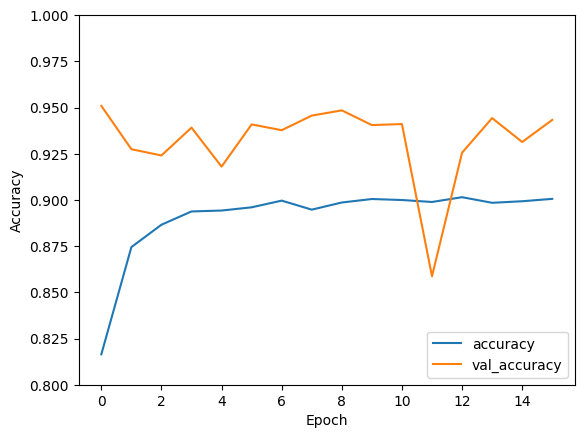

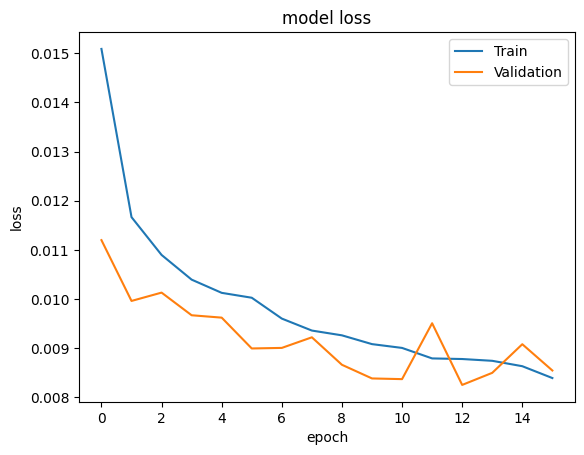

In [11]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
import tensorflow as tf
import keras_tuner as kt

# Build the model using hyperparameters
def build_model(hp):
    model = Sequential()
    # Tune the number of units in the LSTM layer
    units = hp.Int('units', min_value=16, max_value=128, step=16)
    # Tune the activation function
    activation = hp.Choice('activation', values=['relu', 'tanh', 'elu'])
    model.add(LSTM(units, activation=activation, input_shape=(X_train.shape[1], X_train.shape[2])))

    # Tune the dropout rate
    dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)
    model.add(Dropout(dropout_rate))

    # Tune the number of Dense layers and units
    for i in range(hp.Int('num_dense_layers', 1, 7)):
        dense_units = hp.Int(f'dense_units_{i}', min_value=16, max_value=128, step=16)
        model.add(Dense(dense_units, activation=activation))
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(3, activation='softmax'))

    # Tune the learning rate
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Define the loss function with sample weights
    sample_weight = np.array([0.02, 0.44, 0.54])
    #([0.05, 0.45, 0.50])
    #([0.05, 0.50, 0.45]) best
    #([0.041, 0.409, 0.550])
    focal_loss = tf.keras.losses.CategoricalFocalCrossentropy(
        alpha=sample_weight,
        gamma=2.0,
        from_logits=False,
        #label_smoothing=0.0,
        #axis=-1,
        reduction='sum_over_batch_size',
        name='categorical_focal_crossentropy'
    )


#     def focal_loss(gamma=2.0, alpha=[0.041, 0.409, 0.550]):
#         def focal_loss_fixed(y_true, y_pred):
#             epsilon = tf.keras.backend.epsilon()
#             y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
#             y_true = tf.cast(y_true, tf.float32)

#             alpha_t = y_true * alpha + (1 - y_true) * (1 - alpha)
#             p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)

#             fl = -alpha_t * tf.pow(1 - p_t, gamma) * tf.math.log(p_t)
#             return tf.reduce_mean(fl)

#         return focal_loss_fixed

#     # Compile the model with focal loss
#     model.compile(optimizer='adam', loss=focal_loss(gamma=2.0, alpha=[0.041, 0.409, 0.550]), metrics=['accuracy'])

    
    # Compile the model
    model.compile(optimizer=optimizer, loss=focal_loss, metrics=['accuracy', f1_m, precision_m, recall_m])
    return model

# Instantiate the tuner
tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective='val_accuracy',
    max_trials=20,  # You can increase this number to search more hyperparameter combinations
    executions_per_trial=1,
    directory='my_dir',
    project_name='lstm_tuning'
)

# Early stopping callback to prevent overfitting
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Run the hyperparameter search
tuner.search(
    X_train, Y_train,
    epochs=30,
    validation_data=(X_val, Y_val),
    callbacks=[early_stop],
    verbose=1
)

# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete.
The optimal number of units in the LSTM layer is {best_hps.get('units')}.
The optimal activation function is {best_hps.get('activation')}.
The optimal dropout rate is {best_hps.get('dropout_rate')}.
The optimal number of Dense layers is {best_hps.get('num_dense_layers')}.
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")

# Build the model with the optimal hyperparameters
model = tuner.hypermodel.build(best_hps)

# Train the model
history = model.fit(
    X_train, Y_train,
    epochs=30,
    validation_data=(X_val, Y_val),
    callbacks=[early_stop],
    verbose=1
)

model.save("lstm_jan27.keras")

# Evaluate the model on the test set
begin = time.time()
test_loss, test_acc, test_f1, test_precision, test_recall = model.evaluate(X_test,  Y_test, verbose=1)
print(f"Test Accuracy: {test_acc}")
print(f"Test F1 Score: {test_f1}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
end = time.time()
print(f"The testing time is {end - begin} seconds.")

import matplotlib.pyplot as plt
# Check learning curve
# show the history of the model training
# the accuracy of the train and validation for each epoch
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1])
plt.legend(loc='lower right')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'])
plt.show()

In [ ]:
# Retrieve the best hyperparameters sorted by validation accuracy
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]  # Get the best trial

print(f"""
The hyperparameter search is complete.
The optimal number of units in the LSTM layer is {best_hps.get('units')}.
The optimal activation function is {best_hps.get('activation')}.
The optimal dropout rate is {best_hps.get('dropout_rate')}.
The optimal number of Dense layers is {best_hps.get('num_dense_layers')}.
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")


In [16]:
# Get top 5 trials ranked by validation accuracy
top_trials = sorted(tuner.oracle.trials.values(), key=lambda t: t.score, reverse=True)[:5]

for i, trial in enumerate(top_trials):
    print(f"Trial {i+1}: Accuracy = {trial.score}")
    print(trial.hyperparameters.values)
    print("="*50)


Trial 1: Accuracy = 0.9576406478881836
{'units': 16, 'activation': 'relu', 'dropout_rate': 0.2, 'num_dense_layers': 3, 'dense_units_0': 32, 'learning_rate': 0.0032164230487929987, 'dense_units_1': 16, 'dense_units_2': 16, 'dense_units_3': 32, 'dense_units_4': 96, 'dense_units_5': 96, 'dense_units_6': 64}
Trial 2: Accuracy = 0.9566310048103333
{'units': 96, 'activation': 'tanh', 'dropout_rate': 0.1, 'num_dense_layers': 6, 'dense_units_0': 64, 'learning_rate': 0.0021104967409522946, 'dense_units_1': 32, 'dense_units_2': 64, 'dense_units_3': 64, 'dense_units_4': 32, 'dense_units_5': 48, 'dense_units_6': 16}
Trial 3: Accuracy = 0.9541630148887634
{'units': 80, 'activation': 'tanh', 'dropout_rate': 0.1, 'num_dense_layers': 5, 'dense_units_0': 128, 'learning_rate': 0.0021418200870065777, 'dense_units_1': 96, 'dense_units_2': 16, 'dense_units_3': 16, 'dense_units_4': 64, 'dense_units_5': 112, 'dense_units_6': 16}
Trial 4: Accuracy = 0.9525476098060608
{'units': 112, 'activation': 'relu', 'dro

In [17]:
# Build model with best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train model with best hyperparameters
history = best_model.fit(
    X_train, Y_train,
    epochs=50,
    validation_data=(X_val, Y_val),
    callbacks=[early_stop],
    verbose=1
)

# Save the best model
best_model.save("best_lstm_model.keras")


Epoch 1/50
4179/4179 [==============================] - 41s 9ms/step - loss: 0.0116 - accuracy: 0.9024 - f1_m: 0.8717 - precision_m: 0.9382 - recall_m: 0.8229 - val_loss: 0.0098 - val_accuracy: 0.9391 - val_f1_m: 0.9359 - val_precision_m: 0.9500 - val_recall_m: 0.9227
Epoch 2/50
4179/4179 [==============================] - 40s 10ms/step - loss: 0.0101 - accuracy: 0.9238 - f1_m: 0.9167 - precision_m: 0.9430 - recall_m: 0.8930 - val_loss: 0.0096 - val_accuracy: 0.9292 - val_f1_m: 0.9289 - val_precision_m: 0.9465 - val_recall_m: 0.9124
Epoch 3/50
4179/4179 [==============================] - 38s 9ms/step - loss: 0.0097 - accuracy: 0.9287 - f1_m: 0.9240 - precision_m: 0.9466 - recall_m: 0.9034 - val_loss: 0.0090 - val_accuracy: 0.9264 - val_f1_m: 0.9110 - val_precision_m: 0.9647 - val_recall_m: 0.8644
Epoch 4/50
4179/4179 [==============================] - 38s 9ms/step - loss: 0.0094 - accuracy: 0.9250 - f1_m: 0.9190 - precision_m: 0.9462 - recall_m: 0.8943 - val_loss: 0.0089 - val_accuracy

769/769 [==============================] - 2s 2ms/step - loss: 0.0076 - accuracy: 0.9449 - f1_m: 0.9429 - precision_m: 0.9643 - recall_m: 0.9230
Test Accuracy: 0.9448511600494385
Test F1 Score: 0.9429005980491638
Test Precision: 0.9643262624740601
Test Recall: 0.9230331778526306
The testing time is 1.8881165981292725 seconds.


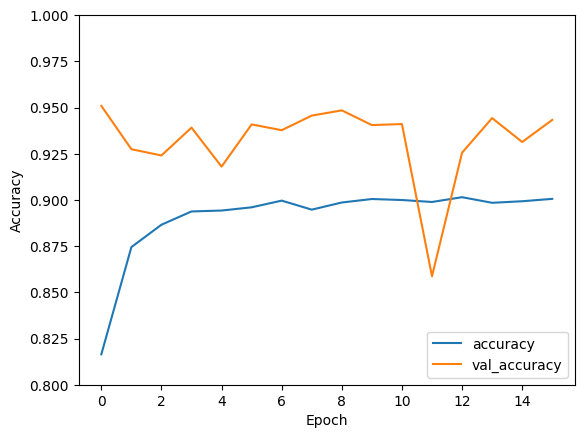

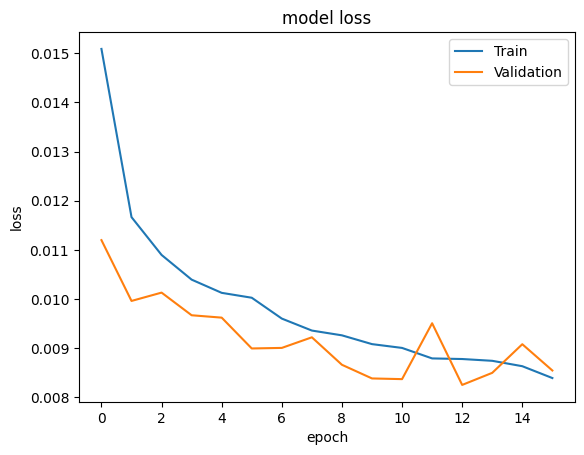

In [12]:
# Evaluate the model on the test set
begin = time.time()
test_loss, test_acc, test_f1, test_precision, test_recall = model.evaluate(X_test,  Y_test, verbose=1)
print(f"Test Accuracy: {test_acc}")
print(f"Test F1 Score: {test_f1}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
end = time.time()
print(f"The testing time is {end - begin} seconds.")

import matplotlib.pyplot as plt
# Check learning curve
# show the history of the model training
# the accuracy of the train and validation for each epoch
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1])
plt.legend(loc='lower right')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'])
plt.show()

## Construct the LSTM model

Please adjust the following parameters
1. The number of units: from 8 to 256, with a step of 16
2. The activation function: tanh, sigmoid, relu, selu, elu, 
3. Dropout form 0 to 0.6, with a step of 0.1
4. Loss: "mse", "mape", keras.losses.SparseCategoricalCrossentropy(from_logits=True), tf.keras.losses.CategoricalCrossentropy(from_logits=True), tf.keras.losses.BinaryCrossentropy(from_logits=True)

For each configuration,
Please record: train accuracy, test accuracy, train time and test time

Please plot the result for each configuration.

Finally, please try all possible configurations to check if it is possible to drag it to 99% accurate. It is better to write a program to automate this process.

In [17]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout
#from keras.layers import CuDNNLSTM
from keras.layers import Dense
import tensorflow as tf

# The hyperparameter search is complete.
# The optimal number of units in the LSTM layer is 48.
# The optimal activation function is tanh.
# The optimal dropout rate is 0.4.
# The optimal number of Dense layers is 2.
# The optimal learning rate for the optimizer is 0.0008886176350890356.

units = 48
#loss_func = tf.keras.losses.BinaryCrossentropy(from_logits=True)
loss_func = tf.keras.losses.CategoricalCrossentropy(from_logits=True)


model = Sequential()

# Optimal LSTM layer
#model.add(LSTM(48, activation='tanh', input_shape=(5, 6)))
model.add(LSTM(units, activation='tanh', batch_input_shape=(None, 5, 6)))

# Dropout with the optimal rate
model.add(Dropout(0.4))

# Add two Dense layers as per optimal tuning
model.add(Dense(16, activation='elu'))
model.add(Dropout(0.4))  # Keep dropout consistent for Dense layers
model.add(Dense(16, activation='elu'))
model.add(Dropout(0.4))

# Output layer
model.add(Dense(3, activation='softmax'))

sample_weight=np.array([0.05, 0.45, 0.60])

# Define the optimizer with a specific learning rate
learning_rate = 0.0008886176350890356
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

focal_loss = tf.keras.losses.CategoricalFocalCrossentropy(
    alpha=sample_weight,
    gamma=2.0,
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    reduction='sum_over_batch_size',
    name='categorical_focal_crossentropy'
)
model.compile(optimizer=optimizer, loss=focal_loss, metrics=['accuracy', f1_m,precision_m, recall_m])

import time
begin = time.time()
history = model.fit(X_train, Y_train, epochs=50, validation_data=(X_val, Y_val), verbose=1)

end = time.time()
print(f"The training time is {end - begin} seconds.")


2024-10-28 17:49:43.614460: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1636] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78408 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:07:00.0, compute capability: 8.0
2024-10-28 17:49:43.616609: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1636] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 78408 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:0f:00.0, compute capability: 8.0
2024-10-28 17:49:43.618473: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1636] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 78408 MB memory:  -> device: 2, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:47:00.0, compute capability: 8.0
2024-10-28 17:49:43.620377: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1636] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 78408 MB memory:  -> device: 3, name: NVIDIA A100-SXM4-80GB, pci bu

Epoch 1/50


2024-10-28 17:49:46.676228: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2024-10-28 17:49:46.710583: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:625] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-10-28 17:49:46.727021: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f93b2ef2a60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-28 17:49:46.727079: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2024-10-28 17:49:46.727086: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2024-10-28 17:49:46.727092: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (2): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2024-10-28 17:49:46.727097: I tensorflow/compil

2306/2306 [==============================] - 12s 4ms/step - loss: 0.0180 - accuracy: 0.9073 - f1_m: 0.8707 - precision_m: 0.9484 - recall_m: 0.8151 - val_loss: 0.0135 - val_accuracy: 0.9566 - val_f1_m: 0.9552 - val_precision_m: 0.9661 - val_recall_m: 0.9449
Epoch 2/50
2306/2306 [==============================] - 9s 4ms/step - loss: 0.0145 - accuracy: 0.9359 - f1_m: 0.9227 - precision_m: 0.9580 - recall_m: 0.8910 - val_loss: 0.0128 - val_accuracy: 0.9331 - val_f1_m: 0.9311 - val_precision_m: 0.9542 - val_recall_m: 0.9097
Epoch 3/50
2306/2306 [==============================] - 10s 4ms/step - loss: 0.0138 - accuracy: 0.9398 - f1_m: 0.9296 - precision_m: 0.9613 - recall_m: 0.9010 - val_loss: 0.0125 - val_accuracy: 0.9451 - val_f1_m: 0.9425 - val_precision_m: 0.9603 - val_recall_m: 0.9258
Epoch 4/50
2306/2306 [==============================] - 9s 4ms/step - loss: 0.0137 - accuracy: 0.9410 - f1_m: 0.9320 - precision_m: 0.9619 - recall_m: 0.9049 - val_loss: 0.0122 - val_accuracy: 0.9472 - val

769/769 [==============================] - 2s 2ms/step - loss: 0.0093 - accuracy: 0.9547 - f1_m: 0.9531 - precision_m: 0.9646 - recall_m: 0.9423
The testing time is 1.5622358322143555 seconds.


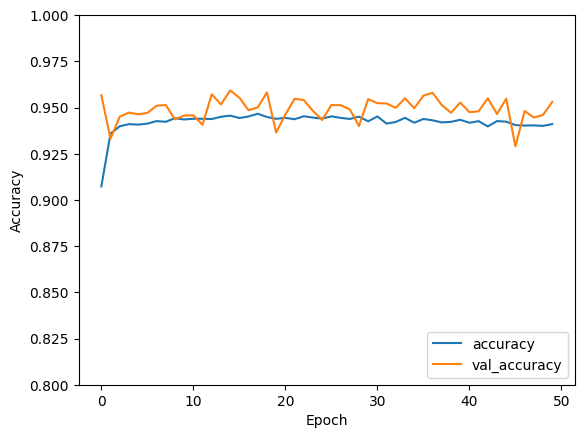

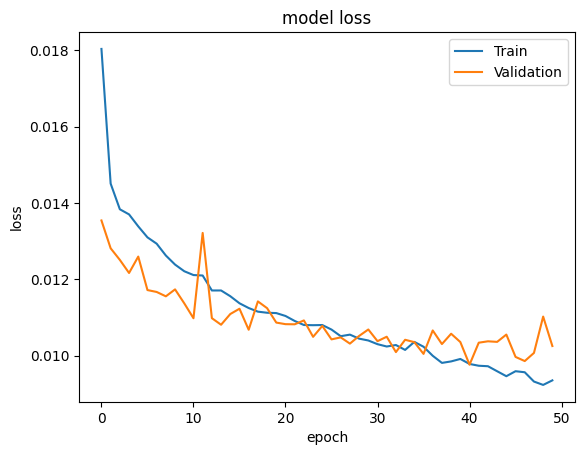

In [18]:
import matplotlib.pyplot as plt
# test the model
begin = time.time()
test_loss, test_acc, test_f1, test_precision, test_recall = model.evaluate(X_test,  Y_test, verbose=1)
end = time.time()
print(f"The testing time is {end - begin} seconds.")
# Check learning curve
# show the history of the model training
# the accuracy of the train and validation for each epoch
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1])
plt.legend(loc='lower right')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'])
plt.show()

Epoch 1/50
2306/2306 [==============================] - 21s 8ms/step - loss: 0.1008 - accuracy: 0.9109 - f1_m: 0.9082 - precision_m: 0.9272 - recall_m: 0.8929 - val_loss: 0.0293 - val_accuracy: 0.9431 - val_f1_m: 0.9416 - val_precision_m: 0.9576 - val_recall_m: 0.9266
Epoch 2/50
2306/2306 [==============================] - 19s 8ms/step - loss: 0.0936 - accuracy: 0.9243 - f1_m: 0.9227 - precision_m: 0.9354 - recall_m: 0.9107 - val_loss: 0.0349 - val_accuracy: 0.9320 - val_f1_m: 0.9296 - val_precision_m: 0.9397 - val_recall_m: 0.9200
Epoch 3/50
2306/2306 [==============================] - 19s 8ms/step - loss: 0.0911 - accuracy: 0.9267 - f1_m: 0.9250 - precision_m: 0.9391 - recall_m: 0.9117 - val_loss: 0.0332 - val_accuracy: 0.9359 - val_f1_m: 0.9347 - val_precision_m: 0.9447 - val_recall_m: 0.9253
Epoch 4/50
2306/2306 [==============================] - 19s 8ms/step - loss: 0.0897 - accuracy: 0.9285 - f1_m: 0.9261 - precision_m: 0.9413 - recall_m: 0.9118 - val_loss: 0.0390 - val_accuracy:

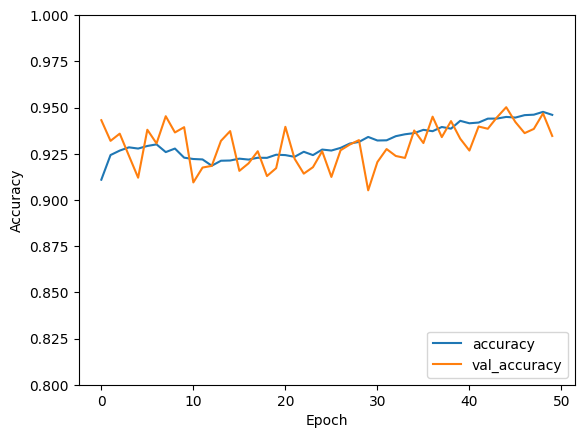

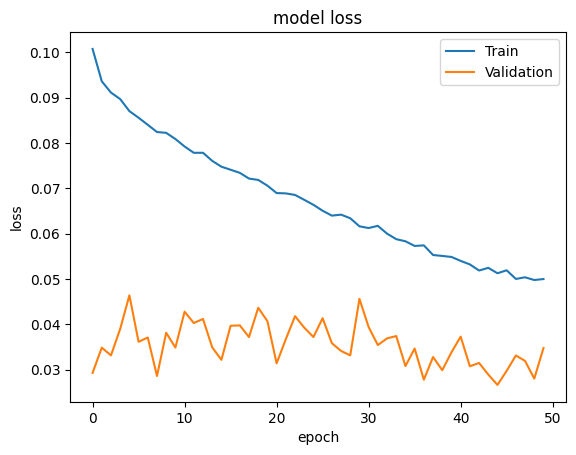

In [18]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout
#from keras.layers import CuDNNLSTM
from keras.layers import Dense

units = 240

model = Sequential()
model.add(LSTM(units, activation='elu', batch_input_shape=(None, 5, 6)))
model.add(Dropout(0.2))
model.add(Dense(32, activation='elu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='mse', metrics=['accuracy', f1_m,precision_m, recall_m])
#
# model = Sequential()
# model.add(CuDNNLSTM(units, batch_input_shape=(None, 5, 4)))
# model.add(Dropout(0.2))
# model.add(Dense(32, activation='elu'))
# model.add(Dropout(0.2))
# model.add(Dense(3, activation='softmax'))
# model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# fit model lstm

import time
begin = time.time()

class_weights = {0: 0.362, 1: 6.17, 2: 13.08}
history = model.fit(X_train, Y_train, epochs=50, batch_size=32, class_weight=class_weights, validation_data=(X_val, Y_val), verbose=1)

end = time.time()
print(f"The training time is {end - begin} seconds.")

import matplotlib.pyplot as plt
# test the model
begin = time.time()
test_loss, test_acc, test_f1, test_precision, test_recall = model.evaluate(X_test,  Y_test, verbose=1)
end = time.time()
print(f"The testing time is {end - begin} seconds.")
# Check learning curve
# show the history of the model training
# the accuracy of the train and validation for each epoch
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1])
plt.legend(loc='lower right')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'])
plt.show()

# Prepare Prediction Data

In [38]:
#prediction for training data

# separate features and labels
# lstm_features_all = pd.read_csv("ATL03_labeled_data/ATL03_ow_labeled_10m_5km_corrected_new_sea_surface_LSTM_ann_prepared_new_param.csv")
lstm_features_all = pd.read_csv("ATL03_labeled_data/ATL03_cor_label_LSTM_ann_prepared.csv")

lstm_labels_all = lstm_features_all.pop('label')
lstm_track_all = lstm_features_all.pop('track')

# normalized the features
def norm(x, M = 1, m = 0):

    # Normalize the input data
    # output = (x-m)/(M-m) # Max-min normalization
    output = (x-x.mean())/(M-x.std()) # mean-std normalization
    return output

norm_lstm_features_all = norm(lstm_features_all)

np_array_all = norm_lstm_features_all.to_numpy()
print(np_array_all.shape)
new_lstm_features_all = []
for row in np_array_all:
  # construct features array
    point_r2 =  row[1:9]
    point_r1 =  row[9:17]
    point_0 = row[17:25]
    point_l1 = row[25:33]
    point_l2 = row[33:41]
    new_lstm_features_all.append([point_r2, point_r1, point_0, point_l1, point_l2])

new_lstm_features_all = np.array(new_lstm_features_all)
print(new_lstm_features_all.shape) # the X array inputshape = [5,4]
print(new_lstm_features_all)  

(222856, 41)
(222856, 5, 8)
[[[-8.44130165e-01  3.70672281e-02 -5.90192105e-01 ... -1.80730238e+00
   -7.14335431e-01 -3.98567224e-01]
  [-8.23470581e-01  1.68601288e-02 -5.70539474e-01 ... -2.93882412e-03
   -7.14428575e-01 -3.98649327e-01]
  [-9.02429403e-01  1.31918624e-02 -6.45597849e-01 ... -9.56975002e-01
   -7.14499039e-01 -3.98699627e-01]
  [-8.94301295e-01  6.10002819e-04 -6.37868395e-01 ... -2.01266714e+00
   -7.14578343e-01 -3.98733891e-01]
  [-9.51608557e-01 -7.65913694e-03 -6.92325474e-01 ... -3.74636087e-01
   -7.14640233e-01 -3.98758462e-01]]

 [[-8.23426519e-01  1.68712364e-02 -5.70511441e-01 ... -3.01973926e-03
   -7.14335431e-01 -3.98567224e-01]
  [-9.02557339e-01  1.32007112e-02 -6.45717632e-01 ... -9.56819605e-01
   -7.14428575e-01 -3.98649327e-01]
  [-8.94321935e-01  6.11465307e-04 -6.37891117e-01 ... -2.01283211e+00
   -7.14499039e-01 -3.98699627e-01]
  [-9.51720076e-01 -7.65436272e-03 -6.92449263e-01 ... -3.74560006e-01
   -7.14578343e-01 -3.98733891e-01]
  [-8.8

In [39]:
# data_new_lstm_features = new_lstm_features.copy()
# data_norm_lstm_features = norm_lstm_features.copy()
data_new_lstm_features = new_lstm_features_all.copy()
data_norm_lstm_features = norm_lstm_features_all.copy()

prediction = model.predict(data_new_lstm_features)

6965/6965 [==============================] - 10s 1ms/step


In [40]:
print(data_new_lstm_features.shape)
#data_new_lstm_features

(222856, 5, 8)


In [41]:
data_norm_lstm_features.shape
#data_norm_lstm_features

(222856, 41)

In [42]:
# def reverse_norm(normalized_x, original_x, M = 1):
#     mean = original_x.mean()
#     std = original_x.std()
#     original_value = normalized_x * (M - std) + mean
#     return original_value

# # Example usage:
# import numpy as np
# import pandas as pd

# # Sample data
# lstm_features = pd.DataFrame({
#     'feature1': [10, 20, 30, 40, 50],
#     'feature2': [15, 25, 35, 45, 55]
# })

# # Normalize the features
# def norm(x, M = 1, m = 0):
#     output = (x - x.mean()) / (M - x.std()) # mean-std normalization
#     return output

# norm_lstm_features = norm(lstm_features)
# print("Normalized features:")
# print(norm_lstm_features)

# # Reverse the normalization
# reversed_features = reverse_norm(norm_lstm_features, lstm_features, M=1)
# print("\nReversed features:")
# print(reversed_features)


In [43]:
df = pd.DataFrame(prediction)
df.columns = ['pred_label0', 'pred_label1', 'pred_label2']

data_norm_lstm_features['pred_label0'] = df['pred_label0']
data_norm_lstm_features['pred_label1'] = df['pred_label1']
data_norm_lstm_features['pred_label2'] = df['pred_label2']

df = pd.DataFrame(lstm_labels_multi)
df.columns = ['label0', 'label1', 'label2']
data_norm_lstm_features['label0'] = df['label0']
data_norm_lstm_features['label1'] = df['label1']
data_norm_lstm_features['label2'] = df['label2']
# print(columns_list)

columns_list = data_norm_lstm_features.columns.tolist()
print(columns_list)

# List of columns to remove
columns_to_remove = ['Unnamed: 0', 
                     'h_cor_mean-2', 'h_diff-2', 'rel_height_min_elev-2', 'height_sd-2', 'pcnth_mean-2', 'pcnt_mean-2', 'bcnt_mean-2', 'brate_mean-2',
                     'h_cor_mean-1', 'h_diff-1', 'rel_height_min_elev-1', 'height_sd-1', 'pcnth_mean-1', 'pcnt_mean-1', 'bcnt_mean-1', 'brate_mean-1',
                     'h_cor_mean1', 'h_diff1', 'rel_height_min_elev1', 'height_sd1', 'pcnth_mean1', 'pcnt_mean1', 'bcnt_mean1', 'brate_mean1',
                     'h_cor_mean2', 'h_diff2', 'rel_height_min_elev2', 'height_sd2', 'pcnth_mean2', 'pcnt_mean2', 'bcnt_mean2', 'brate_mean2']

# Remove the specified columns
data_norm_lstm_features = data_norm_lstm_features.drop(columns=columns_to_remove)

display(data_norm_lstm_features)
# data_norm_lstm_features.to_csv("data_norm_cor_label_lstm_features_pred.csv")
data_norm_lstm_features.to_csv("data_norm_cor_label_lstm_features_pred_training.csv")
del data_norm_lstm_features

['Unnamed: 0', 'h_cor_mean-2', 'h_diff-2', 'rel_height_min_elev-2', 'height_sd-2', 'pcnth_mean-2', 'pcnt_mean-2', 'bcnt_mean-2', 'brate_mean-2', 'h_cor_mean-1', 'h_diff-1', 'rel_height_min_elev-1', 'height_sd-1', 'pcnth_mean-1', 'pcnt_mean-1', 'bcnt_mean-1', 'brate_mean-1', 'h_cor_mean0', 'h_diff0', 'rel_height_min_elev0', 'height_sd0', 'pcnth_mean0', 'pcnt_mean0', 'bcnt_mean0', 'brate_mean0', 'h_cor_mean1', 'h_diff1', 'rel_height_min_elev1', 'height_sd1', 'pcnth_mean1', 'pcnt_mean1', 'bcnt_mean1', 'brate_mean1', 'h_cor_mean2', 'h_diff2', 'rel_height_min_elev2', 'height_sd2', 'pcnth_mean2', 'pcnt_mean2', 'bcnt_mean2', 'brate_mean2', 'pred_label0', 'pred_label1', 'pred_label2', 'label0', 'label1', 'label2']


,h_cor_mean0,h_diff0,rel_height_min_elev0,height_sd0,pcnth_mean0,pcnt_mean0,bcnt_mean0,brate_mean0,pred_label0,pred_label1,pred_label2,label0,label1,label2
0,-0.902429,0.013192,-0.645598,-0.071838,-1.259319,-0.956975,-0.714499,-0.398700,0.678570,0.313848,7.582104e-03,1,0,0
1,-0.894322,0.000611,-0.637891,-0.018590,-0.833811,-2.012832,-0.714499,-0.398700,0.704364,0.292624,3.012016e-03,1,0,0
2,-0.951740,-0.007653,-0.692471,-0.025954,-0.696650,-0.374475,-0.714499,-0.398700,0.670132,0.320007,9.860680e-03,1,0,0
3,-0.882481,-0.006407,-0.626635,-0.000168,-2.395889,-1.631871,-0.714499,-0.398700,0.700492,0.296025,3.482611e-03,1,0,0
4,-0.765506,0.006787,-0.515442,0.048640,-1.582706,-2.405302,-0.714499,-0.398700,0.714722,0.283328,1.950131e-03,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222851,1.730009,0.022738,1.455865,0.228974,-0.506497,-0.570686,0.046075,0.243887,0.855048,0.144950,1.076115e-06,1,0,0
222852,2.099406,0.012096,1.807003,0.085204,-0.244645,-1.214501,0.046075,0.243887,0.807686,0.192293,2.125417e-05,1,0,0
222853,2.106532,0.031520,1.813777,0.128539,-0.815107,-0.863775,0.046075,0.243887,0.866108,0.133892,4.755342e-07,1,0,0
222854,1.793157,0.093251,1.515892,0.079236,1.494796,0.790524,0.046075,0.243887,0.959832,0.040168,3.080026e-12,1,0,0


In [44]:
#prediction for all data

# separate features and labels
lstm_features_all = pd.read_csv("ATL03_labeled_data/ATL03_ow_labeled_10m_5km_corrected_new_sea_surface_LSTM_ann_prepared_new_param_2.csv")
# lstm_features_all = pd.read_csv("ATL03_labeled_data/ATL03_cor_label_LSTM_ann_prepared_26..csv")

lstm_labels_all = lstm_features_all.pop('label')
lstm_track_all = lstm_features_all.pop('track')

# normalized the features
def norm(x, M = 1, m = 0):

    # Normalize the input data
    # output = (x-m)/(M-m) # Max-min normalization
    output = (x-x.mean())/(M-x.std()) # mean-std normalization
    return output

norm_lstm_features_all = norm(lstm_features_all)

np_array_all = norm_lstm_features_all.to_numpy()
print(np_array_all.shape)
new_lstm_features_all = []
for row in np_array_all:
  # construct features array
    point_r2 =  row[1:9]
    point_r1 =  row[9:17]
    point_0 = row[17:25]
    point_l1 = row[25:33]
    point_l2 = row[33:41]
    new_lstm_features_all.append([point_r2, point_r1, point_0, point_l1, point_l2])

new_lstm_features_all = np.array(new_lstm_features_all)
print(new_lstm_features_all.shape) # the X array inputshape = [5,4]
print(new_lstm_features_all)  
# data_new_lstm_features = new_lstm_features.copy()
# data_norm_lstm_features = norm_lstm_features.copy()
data_new_lstm_features = new_lstm_features_all.copy()
data_norm_lstm_features = norm_lstm_features_all.copy()

prediction = model.predict(data_new_lstm_features)

df = pd.DataFrame(prediction)
df.columns = ['pred_label0', 'pred_label1', 'pred_label2']

data_norm_lstm_features['pred_label0'] = df['pred_label0']
data_norm_lstm_features['pred_label1'] = df['pred_label1']
data_norm_lstm_features['pred_label2'] = df['pred_label2']

df = pd.DataFrame(lstm_labels_multi)
df.columns = ['label0', 'label1', 'label2']
data_norm_lstm_features['label0'] = df['label0']
data_norm_lstm_features['label1'] = df['label1']
data_norm_lstm_features['label2'] = df['label2']
# print(columns_list)

columns_list = data_norm_lstm_features.columns.tolist()
print(columns_list)

# List of columns to remove
columns_to_remove = ['Unnamed: 0', 
                     'h_cor_mean-2', 'h_diff-2', 'rel_height_min_elev-2', 'height_sd-2', 'pcnth_mean-2', 'pcnt_mean-2', 'bcnt_mean-2', 'brate_mean-2',
                     'h_cor_mean-1', 'h_diff-1', 'rel_height_min_elev-1', 'height_sd-1', 'pcnth_mean-1', 'pcnt_mean-1', 'bcnt_mean-1', 'brate_mean-1',
                     'h_cor_mean1', 'h_diff1', 'rel_height_min_elev1', 'height_sd1', 'pcnth_mean1', 'pcnt_mean1', 'bcnt_mean1', 'brate_mean1',
                     'h_cor_mean2', 'h_diff2', 'rel_height_min_elev2', 'height_sd2', 'pcnth_mean2', 'pcnt_mean2', 'bcnt_mean2', 'brate_mean2']

# Remove the specified columns
data_norm_lstm_features = data_norm_lstm_features.drop(columns=columns_to_remove)

display(data_norm_lstm_features)
data_norm_lstm_features.to_csv("data_norm_cor_label_lstm_features_pred.csv")
# data_norm_lstm_features.to_csv("data_norm_cor_label_lstm_features_pred_training.csv")
del data_norm_lstm_features

(1303685, 41)
(1303685, 5, 8)
[[[-6.71437460e-01 -5.23635549e-03 -6.40084974e-01 ...  1.40847474e+00
    1.40365793e+00  6.28030242e-01]
  [-5.89915950e-01  1.52959922e-03 -5.57267186e-01 ...  1.55074785e+00
    1.40406451e+00  6.28214824e-01]
  [-5.04558367e-01  1.12732412e-02 -4.70475336e-01 ...  1.49398483e+00
    1.40433557e+00  6.28328388e-01]
  [-4.94107089e-01  1.12578178e-02 -4.59858849e-01 ...  1.83496411e+00
    1.40445059e+00  6.28360388e-01]
  [-7.22968260e-01  1.89992895e-02 -6.92557167e-01 ...  1.57917154e+00
    1.40441786e+00  6.28287351e-01]]

 [[-5.89731601e-01  1.52064643e-03 -5.57008642e-01 ...  1.55046465e+00
    1.40365793e+00  6.28030242e-01]
  [-5.04471725e-01  1.12693700e-02 -4.70385794e-01 ...  1.49394715e+00
    1.40406451e+00  6.28214824e-01]
  [-4.94123486e-01  1.12732412e-02 -4.59864745e-01 ...  1.83478843e+00
    1.40433557e+00  6.28328388e-01]
  [-7.23166226e-01  1.90147770e-02 -6.92783382e-01 ...  1.57935058e+00
    1.40445059e+00  6.28360388e-01]
  [-4

,h_cor_mean0,h_diff0,rel_height_min_elev0,height_sd0,pcnth_mean0,pcnt_mean0,bcnt_mean0,brate_mean0,pred_label0,pred_label1,pred_label2,label0,label1,label2
0,-0.504558,0.011273,-0.470475,-0.193696,4.197687,1.493985,1.404336,0.628328,0.594732,0.349306,0.055962,1.0,0.0,0.0
1,-0.494123,0.011273,-0.459865,-0.193696,4.197687,1.834788,1.404336,0.628328,0.604602,0.348003,0.047395,1.0,0.0,0.0
2,-0.723170,0.019030,-0.692768,-0.119177,3.106335,1.579186,1.404336,0.628328,0.602087,0.348437,0.049476,1.0,0.0,0.0
3,-0.499613,0.019657,-0.465447,-0.172302,3.712641,1.323583,1.404336,0.628328,0.595996,0.349153,0.054851,1.0,0.0,0.0
4,-0.848956,0.002793,-0.820672,-0.079367,2.500029,1.323583,1.404336,0.628328,0.582427,0.356401,0.061172,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1303680,1.031080,-0.006189,0.783182,0.019123,1.014578,1.153181,0.732105,0.845848,0.731991,0.267102,0.000906,NaN,NaN,NaN
1303681,1.024642,-0.043630,0.776636,0.076564,-0.696860,0.363137,0.732105,0.845848,0.774369,0.225501,0.000130,NaN,NaN,NaN
1303682,1.273703,-0.048525,1.029891,0.078559,1.610779,0.982779,0.732105,0.845848,0.777440,0.222452,0.000108,NaN,NaN,NaN
1303683,1.055470,-0.090173,0.807983,0.079508,-1.622855,0.301172,0.732105,0.845848,0.692066,0.303281,0.004654,NaN,NaN,NaN
